## Terraforming Mars Cost-Benefit Analysis
<br>
Terraforming Mars is a competitive board game developed by Jacob Fryxelius and published by FryxGames in 2016. Players take on the role of corporations tasked with making Mars habitable through the raising of the oxygen level, temperature, and ocean coverage, as well as sundry other projects to progress humanity.

Currently sitting at #4 on BoardGameGeek's ranked board game list, Terraforming Mars has found broad popularity among strategy board gamers in large part due to its variety and complexity. With 208 unique cards and 12 distinct corporations, players are put into an endless assortment of scenarios. This incredible depth means that players must often intuit their next move rather than deduce it from values and probabilities.

In a bid to add more deduction back into the equation, this analysis aims to take every card in Terraforming Mars and boil it down to a single value in credits for a given generation and player count in order to demonstrate a simple value-comparison.

<br></br>

<details>
    <summary>Glossary</summary>  
    
* **Corporation**: Each of the 12 cards that every player chooses from at the beginning of the game. Confers starting resources and a special ability
* **Credits**: MegaCredits, the game's central resource
* **Generation**: often abbreviated to "gen", a single round of play comprised of several turns
* **Project**: Each of the 208 cards played during an action
* **Research**: The first phase of each generation, where the players draw projects and then decide how many of them to put into their hand for 3 credits each
* **Resource**: A cube placed on a project to represent, most commonly, a microbe or animal although there are a couple of additional resource types
* **Standard Project**: One of several actions that are always available and have a cost in credits, but don't require playing a card.
* **Tag**: A symbol that represents the type of industry used to complete a project. Most projects have at least one tag and many have two or three
* **Terraforming Rating**: abbreviated to "TR", a measure of a player's success in terraforming. Each point of TR is worth 1 vp as well as an additional credit each generation.
* **Turn**: A player taking one or two actions
* **Victory Points**: abbreviated to "vp", the player with the most of these at the end of the game wins
    
</details>

### Index:

1. [External Data Processing](#External-Data-Processing) 
2. [Variable Definitions](#Variable-Definitions)
3. [Function Definitions](#Function-Definitions)
4. [Basic Project Valuation](#Basic-Project-Valuation)
5. [Special Cases](#Special-Cases)
6. [Analysis](#Analysis)
7. [Conclusion](#Conclusion)

In [1]:
import numpy as np
from statistics import mean, median
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import csv
import ast
import math

#sns.set()
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### External Data Processing
<br></br>
<sup>[index](#Index:)</sup>

The `base_cards` database contains information about each card (referred to in-game as *projects*)  and follows a couple of conventions:
* When a resource is written in uppercase it refers to that resource's production, whereas when written in lowercase it refers to the resource itself.
* All resource nouns are written in the singular in order to simplify referencing.

<details>
    <summary>base_cards information</summary>

Each project contains the following columns:  
* Title: The name of the project
* Game: Terraforming Mars contains two versions of the game, a simple, learning version called "base" and the full version called "corporate" which merely adds more projects and corporations to the game. The full version is used for the purposes of this analysis and so both "base" and "corporate" cards are present
* Type: There are three project types: *automated*, *active*, and *event* 
    * Automated cards are triggered once when played, but the "tags" they show can further influence the gameplay
    * Events are similar except they are turned face down after played so their tags don't contribute to future gameplay
    * Active cards are those that contain either persistent passive benefits or an active ability that may be used up to once per generation
* Primary Cost: The cost, in MegaCredits, to play the card
* Additional Cost: Any additional resources that may need to be spent when playing the card
* Tags: Symbols most cards contain that convey the type of industry involved in completing the project. The effects of some cards are multiplied by the number of a type of tag on the cards a player has previously played
* Prerequisites: Some projects require not only payment but that a certain condition be met, such as any of the three terraforming measures (oceans, oxygen, and temperature) having a minimum or maximum value, or that the player has played projects with a minimum number of a type of tag
* Victory Points: Can be a number of points the card is worth or a number based on the amount of resource cubes collected on the card over the course of the game
* Immediate Benefit: The benefit gained at the time of playing a project. Some cards have no immediate benefit
* Passive Benefit: changes the game state for the player who played the project, allowing them to play other projects more cheaply, gain resources whenever a certain action is taken, and other effects
* Active Cost: The cost, if any, required to gain the active benefit
* Active Benefit: May be gained up to once per turn, either for free or by paying the active cost
* Removed from Opponent: Some projects demand that an opponent lose some amount of resources

</details>

The `all_games` database is a collection of stats from over 12,000 individually logged games downloaded from Simeon Simeonov's excellent [Terraforming Mars website](https://ssimeonoff.github.io/). The `base_games` database contains only the matches from `all_games` which were played with the *Corporate* version of the game.

Finally, five two-player games were conducted with the base set and in each of these games, every action is documented as well as the corporations chosen, the numbers of cards purchased, and the final scores. These games combine to form a dataset smaller but of much finer detail than `base_games`. These games are read into DataFrames and then added into a list called `in_depth_games`.

<details>
    <summary>in_depth_games information</summary>
    
Each game contains the following columns:
* Generation: the game's current generation
* Player: the player whose turn it is
* Action: the action taken by the player
* Spent: the number of steel and/or titanium spent as part of the action
* Terraforming: the number of steps completed in any of the three terraforming requirements (oceans, oxygen, and temperature) as a result of the action
* Cities: notes if a city was placed as a result of the action
</details>

In [2]:
# create databases
base_cards = pd.read_csv('TM_base_project_list.csv')
all_games = pd.read_csv('games_list.csv')
base_games = all_games[(all_games.expansions == "['CORPORATE']") & (all_games.map == "THARSIS")]

in_depth_game_1 = pd.read_csv('Game_1.csv')
in_depth_game_2 = pd.read_csv('Game_2.csv')
in_depth_game_3 = pd.read_csv('Game_3.csv')
in_depth_game_4 = pd.read_csv('Game_4.csv')
in_depth_game_5 = pd.read_csv('Game_5.csv')

in_depth_games = [in_depth_game_1, in_depth_game_2, in_depth_game_3, 
                      in_depth_game_4, in_depth_game_5]

# determine the length of the longest game in in_depth_games
game_lengths = []
for game in in_depth_games:
    game_lengths.append(max([int(x) for x in game.Generation if x not in ['Last', 'Final']]))
    
max_gen = max(game_lengths)

#display(in_depth_game_5)
display(base_cards)

Title       Game       Type  Primary_Cost  \
0                Acquired Company  corporate  automated            10   
1           Adaptation Technology       base     active            12   
2                  Adapted Lichen       base  automated             9   
3                 Advanced Alloys  corporate     active             9   
4             Advanced Ecosystems       base  automated            11   
5     Aerobraked Ammonia Asteroid       base      event            26   
6                      AI Central  corporate     active            21   
7                           Algae       base  automated            10   
8         Anti-Gravity Technology  corporate     active            14   
9                            Ants       base     active             9   
10                Aquifer Pumping       base     active            18   
11                 Archaebacteria       base  automated             6   
12                   Arctic Algae       base     active            12   
13                Artificial Lake       base  automated            15   
14      Artificial Photosynthesis       base  automated            12   
15                       Asteroid       base      event            14   
16                Asteroid Mining       base  automated            30   
17     Asteroid Mining Consortium  corporate  automated            13   
18   Beam from a Thorium Asteroid       base  automated            32   
19                   Big Asteroid       base      event            27   
20             Biomass Combustors       base  automated             4   
21                          Birds       base     active            10   
22               Black Polar Dust       base  automated            15   
23              Breathing Filters       base  automated            11   
24               Bribed Committee  corporate      event             7   
25            Building Industries  corporate  automated             6   
26                         Bushes       base  automated            10   
27              Business Contacts  corporate      event             7   
28               Business Network  corporate     active             4   
29           Callisto Penal Mines  corporate  automated            24   
30                        Capital       base  automated            26   
31           Carbonate Processing       base  automated             6   
32             Caretaker Contract  corporate     active             3   
33                         Cartel  corporate  automated             8   
34         CEO’s Favorite Project  corporate      event             1   
35                  Cloud Seeding       base  automated            11   
36        Colonizer Training Camp       base  automated             8   
37                          Comet       base      event            21   
38            Commercial District  corporate  automated            16   
39             Convoy From Europa       base      event            15   
40           Corporate Stronghold  corporate  automated            11   
41                    Cupola City       base  automated            16   
42                    Decomposers       base     active             5   
43              Deep Well Heating       base  automated            13   
44                    Deimos Down       base      event            31   
45        Designed Microorganisms       base  automated            16   
46             Development Center  corporate     active            11   
47                   Domed Crater       base  automated            24   
48                     Dust Seals       base  automated             2   
49                 Earth Catapult  corporate     active            23   
50                   Earth Office  corporate     active             1   
51                Ecological Zone       base     active            12   
52               Electro Catapult  corporate     active            17   
53                  Energy Saving       base  automated            15   
54           

### Variable Definitions
<br></br>
<sup>[index](#Index:)</sup>  
<sup><sup>[number of generations per game](#Number-of-Generations-per-Game)</sup></sup>  
<sup><sup>[main variables](#Main-Variables)</sup></sup>  
<sup><sup>[number of cards played](#Number-of-Cards-Played)</sup></sup>  
<sup><sup>[number of cities played](#Number-of-Cities-Played)</sup></sup>  
<sup><sup>[average rate of terraforming](#Average-Rate-of-Terraforming)</sup></sup>  
<sup><sup>[tile placement](#Tile-Placement)</sup></sup>  
<sup><sup>[project tags](#Project-Tags)</sup></sup>  
<sup><sup>[special case projects](#Special-Case-Projects)</sup></sup>

#### Number of Generations per Game

Terraforming Mars lasts a variable number of generations. An average number of generations for each player count is derived from `base_games`. These will be used to determine the income which will be generated over the remainder of the game for a given card after the generation during which it is played.<br></br>
<br></br>

<details>
    <summary>Methodology</summary>
    For each player count, the final generations of all logged games in `base_games` are averaged and then rounded and finally converted to an integer for readability. The averages are then packed into a dictionary to be referenced in future functions.
</details>

<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [3]:
# determine generation averages per player count
last_gen_2p = int(round(base_games[base_games.players == 2].generations.mean()))
last_gen_3p = int(round(base_games[base_games.players == 3].generations.mean()))
last_gen_4p = int(round(base_games[base_games.players == 4].generations.mean()))
last_gen_5p = int(round(base_games[base_games.players == 5].generations.mean()))

last_gens = {
            'last_gen_2p': last_gen_2p,
            'last_gen_3p': last_gen_3p,
            'last_gen_4p': last_gen_4p,
            'last_gen_5p': last_gen_5p
           }

print(f'''
Average length of game in generations:
2p: {last_gen_2p}
3p: {last_gen_3p}
4p: {last_gen_4p}
5p: {last_gen_5p}
''')


Average length of game in generations:
2p: 13
3p: 11
4p: 10
5p: 10



#### Main Variables

Next, each resource in the game must be converted to a number of credits. The [standard projects](https://3.bp.blogspot.com/-fs7vQZGRFs4/XAjAYOSBspI/AAAAAAAAFSA/kInbyuaLoLc0PANwJeFDpJditT5Ims3_wCLcBGAs/s1600/terraforming-mars-standard-projects-1.jpg) are set as listed on the game board, and steel and titanium as listed on the [player boards](https://cf.geekdo-images.com/medium/img/qa7YwBE6pc-ZR0relFRrzUAlQXw=/fit-in/500x500/filters:no_upscale()/pic2891980.jpg).  

Plants and heat are set by dividing 8 into the values for the temperature and greenery standard projects. 8 is the number of plants required to place a greenery tile, and the number of heat required to raise the temperature.

For energy, it was necessary to borrow some information from one of the expansions: _Colonies_. In order to trade with a colony, players must spend either 9 credits, 3 titanium, or 3 energy. This suggests that 1 energy = 1 titanium = 3 credits.  

Drawing a project is valued at 4 credits, combining the price to buy a project (3 credits) with the 1 credit gained from discarding it using the "Sell patents" standard project.  
In addition, there is a 2 credit opportunity cost added on that represents the chance to obtain a worthwhile project.  
Discarding a project is valued at a loss of 4 credits: the price to buy the project into hand plus the 1 credit that could be gained from selling it. Since the project has already been seen, there is no loss of opportunity.<br></br>
<br>
<details>
    <summary>Methodology</summary>
    First the standard projects and resources are defined. The production functions account for the number of remaining generations.  
    
There is an additional production phase after the final generation, but for the most part there are only two resources for which the final production matters: plants, which can then be converted into greeneries one final time and credits, which determine the winner in the event of a tie. 
    
Then dictionaries are defined with references to these values for later use, including one for resources which is not yet populated.
</details>

<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [4]:
# variable definitions

# standard projects
temperature = 14
ocean = 18
greenery = 23
def city(income):
    return 25 - (income + 1)

# resources
credit = 1
steel = 2
titanium = 3
plant = greenery / 8
heat = temperature / 8
energy = 3
opportunity = 2
draw = 4 + opportunity
discard = 4

# production
def CREDIT(income):
    return income + 1    # 1 is added for final production
def STEEL(income):
    return steel * income
def TITANIUM(income):
    return titanium * income
def PLANT(income):
    return plant * (income + 1)    # 1 is added for final production
def ENERGY(income):
    return energy * income
def HEAT(income):
    return heat * income

vars_dict_static = {'temp':temperature, 'ocean':ocean, 'greenery':greenery, 'credit':credit, 
                    'steel':steel, 'titanium':titanium, 'plant':plant, 'heat':heat, 'energy':energy, 
                    'draw':draw}

vars_dict_variable = {'city':city, 'CREDIT':CREDIT, 'STEEL':STEEL, 'TITANIUM':TITANIUM, 
                      'PLANT':PLANT, 'ENERGY':ENERGY, 'HEAT':HEAT}

vars_dict_resource = {}

#### Number of Cards Played

The valuation of certain projects, such as [Anti-Gravity Technology](https://terraformingmars.cards/card/anti-gravity-technology) and  [Space Station](https://terraformingmars.cards/card/space-station), depends on knowing the average number of cards played in a given generation. This is simply an average, per generation, taken from the five games in the `in_depth_games` list.
<br>  
<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [5]:
# determine average number of projects played per generation
projects_played_lists = []
for game in in_depth_games:
    
    # find how many generations the game lasted
    game_len = (max([int(row) for row in game.Generation if row not in ['Last', 'Final']]))
    
    # loop through each generation, record the number of projects played by each player, create
    # a list for each player, and add these lists to projects_played_lists for averaging
    p1_projects_per_game = []
    p2_projects_per_game = []
    for gen in range(1, game_len+1):
        p1_projects_per_gen = 0
        p2_projects_per_gen = 0
        for row in game[game.Generation == str(gen)].itertuples():
            if row.Player == 1 and 'played' in row.Action:
                p1_projects_per_gen += 1
            if row.Player == 2 and 'played' in row.Action:
                p2_projects_per_gen += 1
        p1_projects_per_game.append(p1_projects_per_gen)
        p2_projects_per_game.append(p2_projects_per_gen)
    projects_played_lists.append(p1_projects_per_game)
    projects_played_lists.append(p2_projects_per_game)

# use projects_played_lists to record the average number of projects played by a single player per
# generation
ave_projects_per_gen = []
for gen in range(max_gen):
    projects_played = []
    for list in projects_played_lists:
        try:
            projects_played.append(list[gen])
        except IndexError:
            continue
    ave_projects_per_gen.append(sum(projects_played) / len(projects_played))
    
print('The average number of projects played by a player per generation: ')
for idx, ele in enumerate(ave_projects_per_gen):
    print(f'{idx+1}: {ele}')

The average number of projects played by a player per generation: 
1: 2.0
2: 1.1
3: 2.0
4: 1.4
5: 2.1
6: 2.3
7: 2.5
8: 2.7
9: 3.1
10: 3.0
11: 2.9
12: 4.8
13: 4.6
14: 6.6
15: 6.25
16: 6.666666666666667
17: 6.25


#### Number of Cities Played

Some projects are concerned with the number of cities played in a given generation, such as [Rover Construction](https://terraformingmars.cards/card/rover-construction) and [Martian Rails](https://terraformingmars.cards/card/martian-rails). This data is also averaged from `in_depth_games`.
<br>  
<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [6]:
# determine number of cities played over the course of the game
cities_lists = []
for game in in_depth_games:
    
    # find how many generations the game lasted
    game_len = (max([int(row) for row in game.Generation if row not in ['Last', 'Final']]))
    
    # loop through each generation and find how many cities were played by all players, create
    # a list for each game, and add the list to cities_lists for averaging
    cities_per_gen = []
    cities_played = 0
    for gen in range(1, game_len+1):
        for row in game[game.Generation == str(gen)].itertuples():
            if not (isinstance(row.Cities, float) and math.isnan(row.Cities)):
                cities_played += 1
        cities_per_gen.append(cities_played)
    cities_lists.append(cities_per_gen)

# use cities_lists to record the average number of cities on the board at the end of each generation
ave_cities_on_board = []
for gen in range(max_gen):
    cities_on_board = []
    for list in cities_lists:
        try:
            cities_on_board.append(list[gen])
        except IndexError:
            continue
    ave_cities_on_board.append(sum(cities_on_board) / len(cities_on_board))
    
print('The average number of cities on the board per generation: ')
for idx, ele in enumerate(ave_cities_on_board):
    print(f'{idx+1}: {str(ele)}')

The average number of cities on the board per generation: 
1: 0.8
2: 1.0
3: 1.2
4: 1.4
5: 1.8
6: 2.2
7: 2.6
8: 3.4
9: 4.0
10: 4.6
11: 5.2
12: 5.8
13: 7.0
14: 8.6
15: 9.75
16: 13.0
17: 13.0


#### Average Rate of Terraforming

A game of Terraforming Mars ends after three terraforming conditions are met:
* The oxygen level has reached 14%
* The temperature has reached 8°C
* All nine ocean tiles have been placed

The rate at which these conditions are met varies widely from game to game, and so an average per-generation number must be assigned to each condition.

Since the length of the games in `in_depth_games` varies but the length used in value calculation (averaged from `all_games`) does not, the averages below have been conformed to the average game lengths in a [future function](#Terraforming-State).
<br>  
<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [7]:
# determine the average number of each terraforming requirement fulfilled per turn
oceans_per_gen_all_games, oxygen_per_gen_all_games, \
temperature_per_gen_all_games = [[], [], []]

# loop through each game in in_depth_games
for game in in_depth_games:
    oceans_per_gen, oxygen_per_gen, \
    temperature_per_gen = [[], [], []]
    oceans_counter, oxygen_counter, temperature_counter = [0, 0, 0]
    
    # find the length of the game
    game_len = (max([int(row) for row in game.Generation if row not in ['Last', 'Final']]))
    
    # loop through each generation and record how many times each requirement has been advanced,
    # add each to a list, and nest those lists inside a parent list for averaging
    for gen in range(1, game_len+1):
        for row in game[game.Generation == str(gen)].itertuples():
            if not isinstance(row.Terraforming, float):
                for idx, ele in enumerate(row.Terraforming.split(',')):
                    ele = ele.strip()
                    if 'ocean' in ele:
                        oceans_counter += int(ele[0])
                    elif 'oxygen' in ele:
                        oxygen_counter += int(ele[0])
                    elif 'temperature' in ele:
                        temperature_counter += int(ele[0])
        oceans_per_gen.append(oceans_counter)
        oxygen_per_gen.append(oxygen_counter)
        temperature_per_gen.append(temperature_counter)
    oceans_per_gen_all_games.append(oceans_per_gen)
    oxygen_per_gen_all_games.append(oxygen_per_gen)
    temperature_per_gen_all_games.append(temperature_per_gen)

# for each generation and terraforming requirement, add the numbers from each game in
# in_depth_games, average them, and add them to a new list which is referenced in the 
# function cell: Terraforming State
ave_oceans_per_gen, ave_oxygen_per_gen, \
ave_temperature_per_gen = [[], [], []]
ave_terraforming_lists = [ave_oceans_per_gen, ave_oxygen_per_gen,
                          ave_temperature_per_gen]
for gen in range(max_gen):
    oceans_num_list, oxygen_num_list, temperature_num_list = [[], [], []]
    new_terraforming_lists = [oceans_num_list, oxygen_num_list, temperature_num_list]
    all_terraforming_lists = [oceans_per_gen_all_games, oxygen_per_gen_all_games, 
                              temperature_per_gen_all_games]
    for idx, parent_list in enumerate(all_terraforming_lists):
        for child_list in parent_list:
            try:
                new_terraforming_lists[idx].append(child_list[gen])
            except IndexError:
                continue
        ave_terraforming_lists[idx].append(round(sum(new_terraforming_lists[idx]) / 
                                                 len(new_terraforming_lists[idx])))
        
print('Rate of Ocean Terraforming: ', ave_oceans_per_gen)
print('Rate of Oxygen Terraforming: ', ave_oxygen_per_gen)
print('Rate of Temperature Terraforming: ', ave_temperature_per_gen)

Rate of Ocean Terraforming:  [1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 9]
Rate of Oxygen Terraforming:  [0, 0, 0, 0, 1, 1, 1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14]
Rate of Temperature Terraforming:  [0, 0, 1, 1, 1, 2, 3, 3, 4, 5, 8, 11, 12, 14, 17, 18, 19]


#### Tile Placement

Placing a tile on an area with resources allows the player to take those resources, adding to the value of the tile. This additional value is passed on to any project that provides the player with a tile to place. The exceptions are cities, greeneries, and oceans, where the assumption is that the potential for additional resource gain is factored into the cost of the standard projects.

<img src="https://4.bp.blogspot.com/-KVleOqhdyg0/XBxty1rpALI/AAAAAAAAFac/iJsDNEW0SDw6gTK2aHIS0oLc9px5XvzjQCEwYBhgL/s1600/TM%2BOriginal-Mars%2BOnly.jpg" alt="TM map" width="500"/>
<br></br>

<details>
    <summary>Methodology</summary>
    To determine the average value added from these map resources, the total sum of credits gained from the resources of all areas on the map are divided by the total number of areas. This is done separately for ocean areas and non-ocean areas. The two off-world areas and the Noctis City area have been disregarded, since they cannot be placed upon except for unique circumstances.
</details>

<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [8]:
#determine added value from gained resources when placing a tile

tile_land = ((
            2*steel * 3 +
            draw * 3 +
            steel * 3 +
            plant + titanium +
            plant * 10 +
            2*plant * 7 +
            titanium)
            / 48)

tile_ocean = ((
             2*steel +
             draw + opportunity +
             plant * 3 +
             2*plant * 4 +
             2*titanium)
             / 12)

print(f'Placing a land tile is worth {str(round(tile_land, 3))} credits.')
print(f'Placing an ocean tile is worth {str(round(tile_ocean, 3))} credits.')

Placing a land tile is worth 2.372 credits.
Placing an ocean tile is worth 4.135 credits.


#### Project Tags

Several projects provide benefits based on the number of projects with a specific tag that a player has previously played, and so it must be determined the chance that any given project contains any of the tag types.<br></br>
<br></br>
<details>
    <summary>Methodology</summary>
    For each tag type, the number of projects with that tag is divided by the total number of projects to determine the chance that a project drawn contains that tag.  
    
Then, they are divided into `chance_tag_played` and `chance_tag_showing`. This is because some projects with one tag type might also have an event tag. Tags on event projects are considered when the project is played, but the card is subsequently flipped face-down and its tags are no longer counted. `chance_tag_showing` disregards any such cards.
    
Lastly, the two categories of tag types are placed into dictionaries for future referencing.
</details>

<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [9]:
# chance to draw each tag type

# Earth
earth_tags = base_cards[base_cards.Tags.str.contains('earth', na=False)]
chance_earth_played = len(earth_tags) / len(base_cards)
chance_earth_showing = len(earth_tags[~earth_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Science
science_tags = base_cards[base_cards.Tags.str.contains('science', na=False)]
chance_science_played = len(science_tags) / len(base_cards)
chance_science_showing = len(science_tags[~science_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Plant
plant_tags = base_cards[base_cards.Tags.str.contains('plant', na=False)]
chance_plant_played = len(plant_tags) / len(base_cards)
chance_plant_showing = len(plant_tags[~plant_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Microbe
microbe_tags = base_cards[base_cards.Tags.str.contains('microbe', na=False)]
chance_microbe_played = len(microbe_tags) / len(base_cards)
chance_microbe_showing = len(microbe_tags[~microbe_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Animal
animal_tags = base_cards[base_cards.Tags.str.contains('animal', na=False)]
chance_animal_played = len(animal_tags) / len(base_cards)
chance_animal_showing = len(animal_tags[~animal_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Space
space_tags = base_cards[base_cards.Tags.str.contains('space', na=False)]
chance_space_played = len(space_tags) / len(base_cards)
chance_space_showing = len(space_tags[~space_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Event
event_tags = base_cards[base_cards.Tags.str.contains('event', na=False)]
chance_event_played = len(event_tags) / len(base_cards)

# Building
building_tags = base_cards[base_cards.Tags.str.contains('building', na=False)]
chance_building_played = len(building_tags) / len(base_cards)
chance_building_showing = len(building_tags[~building_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Jovian
jovian_tags = base_cards[base_cards.Tags.str.contains('jovian', na=False)]
chance_jovian_played = len(jovian_tags) / len(base_cards)
chance_jovian_showing = len(jovian_tags[~jovian_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# Power
power_tags = base_cards[base_cards.Tags.str.contains('power', na=False)]
chance_power_played = len(power_tags) / len(base_cards)
chance_power_showing = len(power_tags[~power_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)
# City
city_tags = base_cards[base_cards.Tags.str.contains('city', na=False)]
chance_city_played = len(city_tags) / len(base_cards)
chance_city_showing = len(city_tags[~city_tags.Tags.str.contains('event', na=False)]) \
                       / len(base_cards)

tags_played_dict = {'earth':chance_earth_played, 'science':chance_science_played, 
                    'plant':chance_plant_played, 'microbe':chance_microbe_played, 
                    'animal':chance_animal_played, 'space':chance_space_played,
                    'event':chance_event_played, 'building':chance_building_played, 
                    'jovian':chance_jovian_played,'power':chance_power_played, 
                    'city':chance_city_played}

tags_showing_dict = {'earth':chance_earth_showing, 'science':chance_science_showing, 
                    'plant':chance_plant_showing, 'microbe':chance_microbe_showing, 
                    'animal':chance_animal_showing, 'space':chance_space_showing,
                    'event':chance_event_played, 'building':chance_building_showing, 
                    'jovian':chance_jovian_showing,'power':chance_power_showing, 
                     'city':chance_city_showing}

#### Special Case Projects

The primary value calculation function will suffice for 156 of the 208 cards in the base set. The other 52 are dealt with separately for one of two reasons:

* The card has an effect that is distinctive enough that it requires attention above and beyond that of the 156 base cases.
* The card has a small quirk that only requires a line or two of extra code, but the effect is rare enough that the code is left out of the main function for the sake of concision.

After defining the special case cards, the `base_cards` database is split into `basic_cases` and `special_cases`.  
<br></br>

<sup>[variable definitions](#Variable-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [10]:
# define special case cards to be left out of the main function
special_cases = ['Adaptation Technology', 'Advanced Alloys', 'Anti-Gravity Technology', 'Ants', 
                 'Aquifer Pumping', 'Arctic Algae', 'Business Network', 'Capital', 
                 'CEO’s Favorite Project', 'Commercial District', 'Decomposers', 'Earth Catapult', 
                 'Earth Office', 'Ecological Zone', 'Ganymede Colony', 'GHG Producing Bacteria', 
                 'Herbivores', 'Immigrant City', 'Immigration Shuttles', 
                 'Insulation', 'Inventor’s Guild', 'Io Mining Industries', 'Land Claim', 
                 'Lava Flows', 'Mars University', 'Martian Rails', 'Mass Converter', 'Media Group', 
                 'Mining Area', 'Mining Rights', 'Nitrite Reducing Bacteria', 
                 'Nitrogen-Rich Asteroid', 'Noctis City', 'Olympus Conference', 'Optimal Aerobraking', 
                 'Pets', 'Phobos Space Haven', 'Power Infrastructure',
                 'Predators', 'Protected Habitat', 'Quantum Extractor', 'Regolith Eaters', 
                 'Research Outpost', 'Robotic Workforce', 'Rover Construction', 'Search for Life', 
                 'Shuttles', 'Space Station', 'Special Design', 'Standard Technology', 
                 'Viral Enhancers', 'Water Import from Europa']

basic_cases = base_cards[~base_cards.Title.isin(special_cases)].copy().reset_index(drop=True)

### Function Definitions
<br></br>
<sup>[index](#Index:)</sup>  
<sup><sup>[remaining generations](#Remaining-Generations)</sup></sup>  
<sup><sup>[credits per victory point](#Credits-per-Victory-Point)</sup></sup>  
<sup><sup>[variable initialization](#Variable-Initialization)</sup></sup>  
<sup><sup>[number of projects seen](#Number-of-Projects-Seen)</sup></sup>  
<sup><sup>[microbes](#Microbes)</sup></sup>  
<sup><sup>[animals](#Animals)</sup></sup>  
<sup><sup>[variable scanner](#Variable-Scanner)</sup></sup>  
<sup><sup>[the "per" term](#The-"per"-term)</sup></sup>  
<sup><sup>[the "or" term](#The-"or"-term)</sup></sup>  
<sup><sup>[terraforming state](#Terraforming-State)</sup></sup>  
<sup><sup>[null check](#Null-Check)</sup></sup>  

#### Remaining Generations

The given current generation and player count is used to determine the number of remaining generations based on the [average number of generations per game](#Number-of-Generations-per-Game), which also determines the current income.

In [11]:
# determine number of remaining generations
def rem_gen(generation, player_count):
    global income
    for players in last_gens:
        if str(player_count) in players:
            last_gen = last_gens[players]
    income = last_gen - generation
    return income, last_gen

#### Credits per Victory Point

Victory points (vp) must also be converted to credits. To do this, the three terraforming standard projects are used. These confer a terraforming rating point (TR) and not a victory point. A TR is the same as a vp except that it also provides an income of one credit. This means that while the value of a TR will remain constant over the course of a game, the extra income from the TR must be subtracted from the cost of the project when valuing VP. Thus, similar to the cards themselves, the value of a VP changes over time.

In addition to the generated income, the average bonus credits accrued through tile placement are also factored into the Aquifer and Greenery standard projects when calculating for VP value.  
<br></br>

<details>
    <summary>Methodology</summary>
    To come to a single value for a given generation and player count, the "points per credit" are determined for each of the three standard terraforming projects and then the average is taken. Note that greeneries are worth two points (one for the TR from raising the oxygen, another from the greenery tile itself) and so are calculated accordingly.
</details>

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [12]:
# define credits per victory point
def credits_per_vp(generation, player_count):
    income, last_gen = rem_gen(generation, player_count)
    temp_vp_per_credit = 1/(temperature - income)
    ocean_vp_per_credit = 1/(ocean - income - tile_ocean)
    greenery_vp_per_credit = 2/(greenery - income - tile_land)
    vp_per_credit = (temp_vp_per_credit + ocean_vp_per_credit + greenery_vp_per_credit)/4
    vp = 1/vp_per_credit
    return vp

print('In a two-player game:')
for i in range(1, 14):
    print(f'Gen {i} = {round(credits_per_vp(i, 2), 2)} credits per VP')

In a two-player game:
Gen 1 = 3.15 credits per VP
Gen 2 = 4.49 credits per VP
Gen 3 = 5.74 credits per VP
Gen 4 = 6.93 credits per VP
Gen 5 = 8.07 credits per VP
Gen 6 = 9.19 credits per VP
Gen 7 = 10.29 credits per VP
Gen 8 = 11.37 credits per VP
Gen 9 = 12.44 credits per VP
Gen 10 = 13.49 credits per VP
Gen 11 = 14.55 credits per VP
Gen 12 = 15.59 credits per VP
Gen 13 = 16.63 credits per VP


#### Variable Initialization

The two above functions are used to initialize future functions based on the current generation and player count.  
<br></br>  

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [13]:
#run above functions and determine credits per TR
def initialize(generation, player_count):
    income, last_gen = rem_gen(generation, player_count)
    vp = credits_per_vp(generation, player_count)
    TR = vp + income
    return income, vp, TR, last_gen

#### Number of Projects Seen  
At the beginning of the game, each player draws 10 projects, deciding which to purchase into their hand. On the second and every subsequent generation, each player draws 4 projects for potential purchase. The following function determines the number of unique projects a player has had the opportunity to play based on the current generation. 

It is used primarily in determining the likely number of a certain tag that player may have showing in a given generation.  
<br></br>  

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [14]:
# define the number of cards a player has had the opportunity to play
def projects_seen(generation):
    return 10 + (4 * (generation - 1))

#### Microbes  
Microbes are a resource that get added onto projects, accumulating either to be converted into points at the end of the game or to be spent on terraforming. The relevant effects of all cards that hold microbes have been averaged to determine the value of a microbe in a given generation/player count.  
<br></br>  
<details>
    <summary>Methodology</summary>
The following cards are taken into account when calculating the value of a microbe:  
    
* [Ants](https://terraformingmars.cards/card/ants) - 1 vp per 2 microbes  
* [Decomposers](https://terraformingmars.cards/card/decomposers) - 1 vp per 3 microbes  
* [GHG](https://terraformingmars.cards/card/ghg-producing-bacteria) Producing Bacteria - 1 temp per 2 microbes  
* [Nitrite Reducing Bacteria](https://terraformingmars.cards/card/nitrite-reducing-bacteria) - 1 TR per 3 microbes  
* [Regolith Eaters](https://terraformingmars.cards/card/regolith-eaters) - 1 oxygen per 2 microbes  
* [Tardigrades](https://terraformingmars.cards/card/tardigrades) - 1 vp per 4 microbes
    
After determining the value, `vars_dict_resource` is updated to contain `microbe_val`.
</details>  

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [15]:
# determine microbe value
def microbe_val(generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    ants = vp / 2
    decomposers = vp / 3
    ghg_producing_bacteria = temperature / 2
    nitrite_reducing_bacteria = TR / 3
    regolith_eaters = greenery / 4
    tardigrades = vp / 4
    
    microbes_list = [ants, decomposers, ghg_producing_bacteria, nitrite_reducing_bacteria,
                     regolith_eaters, tardigrades]
    microbe = sum(microbes_list) / len(microbes_list)
    return microbe

vars_dict_resource.update({'microbe':microbe_val})

print('In a two-player game:')
for i in range(1, 14):
    print(f'Gen {i} = {round(microbe_val(i, 2), 2)} credits per microbe')

In a two-player game:
Gen 1 = 3.54 credits per microbe
Gen 2 = 3.8 credits per microbe
Gen 3 = 4.04 credits per microbe
Gen 4 = 4.26 credits per microbe
Gen 5 = 4.48 credits per microbe
Gen 6 = 4.68 credits per microbe
Gen 7 = 4.89 credits per microbe
Gen 8 = 5.09 credits per microbe
Gen 9 = 5.28 credits per microbe
Gen 10 = 5.48 credits per microbe
Gen 11 = 5.67 credits per microbe
Gen 12 = 5.86 credits per microbe
Gen 13 = 6.05 credits per microbe


#### Animals

Animals are the same as microbes except that they are never spent, merely accumulated on cards and then converted to points at the end of the game.  
<br></br>
<details>
    <summary>Methodology</summary>
    
The following cards are taken into account when calculating the value of an animal:  
* Birds - 1 vp per animal
* Fish - 1 vp per animal
* Livestock - 1 vp per animal
* Predators - 1 vp per animal
* Ecological Zone - 1 vp per 2 animals
* Herbivores - 1 vp per 2 animals
* Pets - 1 vp per 2 animals
* Small Animals - 1 vp per 2 animals
    
After determining the value, `vars_dict_resource` is updated to contain `animal_val`.
</details>  

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [16]:
# animal value
# animal_tags = base_cards[base_cards.Tags.str.contains('animal', na=False)]
# display(animal_tags)

def animal_val(generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    birds = fish = livestock = predators = vp
    ecological_zone = herbivores = pets = small_animals = vp/2
    
    animals_list = [birds, fish, livestock, predators, ecological_zone,
                    herbivores, pets, small_animals]
    animal = sum(animals_list) / len(animals_list)
    return animal

vars_dict_resource.update({'animal':animal_val})

print('In a two-player game:')
for i in range(1, 14):
    print(f'Gen {i} = {round(animal_val(i, 2), 2)} credits per animal')

In a two-player game:
Gen 1 = 2.37 credits per animal
Gen 2 = 3.37 credits per animal
Gen 3 = 4.3 credits per animal
Gen 4 = 5.19 credits per animal
Gen 5 = 6.05 credits per animal
Gen 6 = 6.89 credits per animal
Gen 7 = 7.71 credits per animal
Gen 8 = 8.53 credits per animal
Gen 9 = 9.33 credits per animal
Gen 10 = 10.12 credits per animal
Gen 11 = 10.91 credits per animal
Gen 12 = 11.69 credits per animal
Gen 13 = 12.47 credits per animal


#### Variable Scanner

Takes a benefit phrase such as "4 STEEL" or "1 ocean" and converts it into a credit value.  
<br></br>  

<details>
    <summary>Methodology</summary>
    
A list is passed to `vars_scan` that contains each word or number in the benefit (eg. `['4', 'STEEL']`). This simplifies the process of indexing the elements and converting them into values. The benefit phrase is scanned, and if any given word matches an entry in `vars_dict_static`, `vars_dict_variable`, or `vars_dict_resource`, the value associated with that variable is multiplied by the number preceeding it.  
    The terms "TR", "oxygen", and "discard" are also handled.
</details>

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [17]:
# scan a benefit list and returns the benefit value
def vars_scan(benefit_list, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    benefit_value = 0
    
    # finds the variable name within the benefit list and references the various dictionaries
    # to convert it into a credit value, then multiplying that by the number preceding it in
    # the benefit list
    for idx, ele in enumerate(benefit_list):
        
        # vars_dict_static contains constant variables such as "ocean" and "heat"
        if ele in vars_dict_static:
            try:
                benefit_value = int(benefit_list[idx-1]) * vars_dict_static[ele]
            except ValueError: continue
        
        # vars_dict_variable contains variables whose values change based on the number of
        # remaining generations, such as "city" and "PLANT"
        elif ele in vars_dict_variable:
            benefit_value = int(benefit_list[idx-1]) * vars_dict_variable[ele](income)
        
        # vars_dict_resource contains microbes and animals
        elif ele in vars_dict_resource:
            benefit_value = int(benefit_list[idx-1]) * vars_dict_resource[ele]\
            (generation, player_count)
            
        elif ele == 'TR' or ele == 'oxygen':
            benefit_value = int(benefit_list[idx-1]) * TR
            
        elif ele == 'discard':
            benefit_value -= int(benefit_list[idx+1]) * discard
            
    return benefit_value

#### The "per" term

Some card effects provide benefits based on a combination of variables, such as "1 energy per city" or "1 CREDIT per space tag". The left coefficient is calculated using `vars_scan`, while the right is calculated separately.  
<br></br>
<details>
    <summary>Methodology</summary>
    
First the passed list is rejoined into a string and then resplit into the two coefficients to either side of "per". The left coefficient is run through `vars_scan`, while the right coefficient is handled based on the terms "tag", "city", or "event".
    
In the event that the right coefficient is "tag" or "event", the likelihood of a drawn project having that tag is multiplied by the number of projects drawn thusfar (10 + 4 for every generation after the first). The result becomes the value of the right coefficient.
    
If the coefficient is "city", the list `ave_cities_on_board` is consulted to determine the average number of cities on the board for the given generation.
</details>

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [18]:
# take a benefit list with the term "per" and return the benefit value

def per_scan(benefit_list, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    if 'per' in benefit_list:
        
        # rejoin the benefit list into a string, split it at "per", and seperate the two
        # resulting lists into each individual number or word
        per_a, per_b = (' ').join(benefit_list).split(' per ')
        per_a, per_b = per_a.split(' '), per_b.split(' ')
        benefit_a = vars_scan(per_a, generation, player_count)
        
        # most projects are only concerned with the number of tags or events played by a
        # single player, but some are based on the number played by all players
        if 'all' in benefit_list: players = player_count
        else: players = 1
        
        
        if 'tag' in benefit_list:
            for idx, ele in enumerate(benefit_list):
                if ele in tags_showing_dict:
                    benefit_b = (1 / int(benefit_list[idx-2])) * \
                                (tags_showing_dict[ele] * projects_seen(generation) * players)
                                
        elif 'city' in benefit_list:
            for idx, ele in enumerate(benefit_list):
                if ele == 'city':
                    benefit_b = int(benefit_list[idx-1]) * \
                                ave_cities_on_board[generation-1]
                    
        elif 'event' in benefit_list:
            for idx, ele in enumerate(benefit_list):
                if ele == 'event':
                    benefit_b = int(benefit_list[idx-1]) * \
                                (chance_event_played * (projects_seen(generation) * players))

        points_per = benefit_a * benefit_b
        return points_per

#### The "or" term

Some projects provide a choice between two benefits or two active costs. In these cases, the more valuable benefit (or the less valuable cost) is chosen using `or_scan()`.  
<br></br>  

<details>
    <summary>Methodology</summary>
    
The benefit is passed into `ors` as a string and subsequently split into the two benefits on either side of the "or" term. Then each benefit is evaluated and added to `comparison_list`, the greater or lesser of which is returned based on whether the "or" describes a benefit or a cost.
</details>

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [19]:
# take a benefit list with the term "or" and return the more beneficial of the two values

def or_scan(or_benefit, generation, player_count, cost=False):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    or_list = or_benefit.split(' or ')
    or_value, or_val = [0, 0]
    comparison_list = []
    
    for benefit in or_list:
        benefit = benefit.split(' ')
        or_val = vars_scan(benefit, generation, player_count)
        comparison_list.append(or_val)
    if cost == True: or_value = min(comparison_list)
    else: or_value = max(comparison_list)
        
    return or_value

#### Terraforming State  

Under the variable definitions, [average terraforming rates](#Average-Rate-of-Terraforming) were determined. Each of the three lists (oceans, oxygen, and temperature) have a number of entries equal to the length of the longest game recorded in `in_depth_games`. Each entry holds the average number of terraforming steps for that generation.

Because this data was culled from games of different lengths and the projects are to be evaluated based on a single length per player count (the averages from `base_games`), the previous terraforming lists must be condensed down to match the average lengths used in evaluation.
<br></br>  

<details>
    <summary>Methodology</summary>
    
The longest game in `in_depth_games` lasted 17 generations. To condense the lists of average terraforming rates down from 17 to the numbers used for evaluation, the x values are transformed according to the following formula: (x - 1) * comp + 1, where comp holds the following number for each player count:  
* 2 players - .75  
* 3 players - .625  
* 4 players - .5625  
* 5 players - .5625  
    
This condenses the curve down to the correct length in generations, but there are still 17 y values. To pare it down to the requisite number, for any x value with more than one y value, the y values are averaged.
</details>

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [20]:
# Conform the ave_requirements_per_gen lists to the number of average generations per player_count
# determined with base_games

def terraforming(terraforming_process, player_count):
    
    # set x values to equal the lengths of the ave_requirements_per_gen lists
    original_x = [*range(1, 18)]
    
    # transform the x values so that instead of generations 1-17, the length player count matches 
    # the averages taken from base_games to be used in evaulation
    def dict_condensing(terraforming_gen_list, player_count):
        
        if player_count == 2:
            comp = .75
        elif player_count == 3:
            comp = .625
        elif player_count in [4, 5]:
            comp = .5625 
            
        dict_condensed = {(key-1)*comp+1 : value for key, value in
                            zip(original_x, terraforming_gen_list)}
        
        return dict_condensed
    
    # for each x value in dict_compressed, average out the y values
    def dict_averaging(dictionary):
        
        # consolidate dict_condensed to eliminate duplicate x values
        dict_consolidated = {}
        for key, value in dictionary.items():
            if round(key) in dict_consolidated:
                dict_consolidated[round(key)].append(value)
            else:
                dict_consolidated[round(key)] = [value]
        
        # for each x value with multiple y values, take the average of the y values so that only 
        # one x/y pair remains for each generation
        dict_averaged = {}
        for gen in dict_consolidated:
            dict_averaged[gen] = mean(dict_consolidated[gen])
        return dict_averaged
    
    if terraforming_process == 'ocean':
        ocean_dict_condensed = dict_condensing(ave_oceans_per_gen, player_count)
        dict_final = dict_averaging(ocean_dict_condensed)
        
    elif terraforming_process == 'oxygen':
        oxygen_dict_condensed = dict_condensing(ave_oxygen_per_gen, player_count)
        dict_final = dict_averaging(oxygen_dict_condensed)
        
    elif terraforming_process == 'temperature':
        temperature_dict_condensed = dict_condensing(ave_temperature_per_gen, player_count)
        dict_final = dict_averaging(temperature_dict_condensed)
    
    return dict_final
    
print('Oceans: ', terraforming('ocean', 3))
print('Oxygen: ', terraforming('oxygen', 3))
print('Temperature: ', terraforming('temperature', 3))

Oceans:  {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 3.5, 8: 5.5, 9: 7, 10: 8.5, 11: 9}
Oxygen:  {1: 0, 2: 0, 3: 0, 4: 1, 5: 1.5, 6: 3, 7: 5, 8: 9, 9: 11, 10: 12.5, 11: 14}
Temperature:  {1: 0, 2: 0.5, 3: 1, 4: 1.5, 5: 3, 6: 4, 7: 6.5, 8: 11.5, 9: 14, 10: 17.5, 11: 19}


#### Null Check

A simple function to check for NaN in a given cell so that when found, that cell may be ignored.  
<br></br>  

<sup>[function definitions](#Function-Definitions)</sup>  
<sup>[index](#Index:)</sup>

In [21]:
def is_null(x):
    return x is None or (isinstance(x, float) and math.isnan(x))

### Basic Project Valuation

These are the main functions responsible for attaching a value to a project for a given generation and player count.  
<br></br>

<details>
    <summary>Methodology</summary>
To begin with, a function is defined to compute the cost or benefit associated with each column in the database:

* `compute_additional_cost_value` handles any resources beyond the credit cost that must be paid when playing a project
* `compute_victory_points_value` handles the number of victory points a project is worth when it is a static value. Projects that award a variable number of points based on a game state are handled either under `compute_immediate_benefit_value` or `compute_active_benefit_value`
* `compute_immediate_benefit_value` handles the immediate benefit of playing a project.
* `compute_active_benefit_value` handles active benefits that can be gained once per generation. If the active benefit has an associated cost, that cost will be subtracted from the benefit. If the result is positive, it will be added to the project's value. This determination must be made separately for each remaining generation, since some costs or benefits are dependent on income
* `compute_removal_value` handles the resources removed from an opponent. Though the player who
played the project does not gain these resources, they are considered a swing in credits and so are counted towards a project's value

Next a decorator is written to allow for the special cases code to be added in later. The special cases are the 58 projects that require additional code to be evaluated
    
The wrapped function first evaluates the project's primary cost, then runs all of the above functions and adds the returns to the total value of the project. After that is the function to run any special cases code that may be present and add that return to the total value.
    
Finally the value is applied to every row in the DataFrame and added as a new column. Additional columns are added stating the current generation and player count.
    
</details>

<sup>[index](#Index:)</sup>

In [22]:
# Basic project valuation

# ADDITIONAL COST
# subtract the value of any additional costs
def compute_additional_cost_value(add_cost, generation, player_count):
    if is_null(add_cost):
        return 0
    
    value = 0
    
    for idx, ele in enumerate(add_cost.split(',')):
        add_cost_list = ele.strip().split(' ')
        value -= vars_scan(add_cost_list, generation, player_count)
        
    return value


# VICTORY POINTS
# add the value of a static number of victory points
def compute_victory_points_value(victory, vp):
    if is_null(victory) or not victory.strip('-').isdigit():
        return 0
    
    return int(victory) * vp


# IMMEDIATE BENEFIT
# add the value of one or more immediate benefits
def compute_immediate_benefit_value(i_benefit, generation, player_count):
    if is_null(i_benefit):
        return 0

    value = 0
    
    # separate multiple benefits, if any, and evaluate each one
    for idx, ele in enumerate(i_benefit.split(',')):
        i_benefit_list = ele.strip().split(' ')

        # for benefits dependent on the amount of another variable
        if 'per' in i_benefit_list:
            value += per_scan(i_benefit_list, generation, player_count)

        # for benefits with a choice; the larger of the two values is taken
        elif 'or' in i_benefit_list:
            value += or_scan((' ').join(i_benefit_list), generation, player_count)

        # when a project produces an ocean tile to be layed on a land site
        elif 'land' in i_benefit_list and 'ocean' in i_benefit_list:
            value += ocean + tile_land - tile_ocean
        # when a project produces a greenery tile to be layed on an ocean site    
        elif 'ocean' in i_benefit_list and 'greenery' in i_benefit_list:
            value += greenery + tile_ocean - tile_land

        # average resources gained for laying a special tile on the board
        elif 'special' in i_benefit_list:
            if 'ocean' in i_benefit_list:
                value += tile_ocean
            else:
                value += tile_land

         # added value for simple benefits
        else:
            value += vars_scan(i_benefit_list, generation, player_count)

    return value


# ACTIVE BENEFIT
# for the current and each remaining generation, determine if the value of the active benefit 
# exceeds the value of the active cost and if it does, add the difference to total value
def compute_active_benefit_value(a_cost, a_benefit, victory, generation, last_gen, player_count):
    if is_null(a_cost) and is_null(a_benefit):
        return 0

    value = 0
    evaluation_gen = generation

    while evaluation_gen <= last_gen:
        
        # Cost
        if is_null(a_cost):
            cost = 0
        else:
            a_cost_list = a_cost.split(' ')
            
            if 'or' in a_cost:
                cost = or_scan(a_cost, evaluation_gen, player_count, cost=True)
            else:
                cost = vars_scan(a_cost_list, evaluation_gen, player_count)

        # Benefit
        benefit = 0
        
        for benefit_x in a_benefit.split(','):
            benefit_x_split = benefit_x.strip().split(' ')
            
            if 'or' in benefit_x:
                benefit += or_scan(benefit_x, evaluation_gen, player_count)
                
            elif 'on card' in benefit_x:
                number_vp = (int(victory[0]) / int(victory[6])) * int(benefit_x[0])
                current_vp_value = credits_per_vp(evaluation_gen, player_count)
                benefit += number_vp * current_vp_value
                
            else:
                benefit += vars_scan(benefit_x_split, evaluation_gen, player_count)

        if cost < benefit:
            value += benefit - cost

        evaluation_gen += 1

    return value


# REMOVED FROM OPPONENT
# add the value of any resources removed from an opponent
def compute_removal_value(removed, generation, player_count):
    if is_null(removed):
        return 0
    
    value = 0
    
    if 'or' in removed:
        value += or_scan(removed, generation, player_count)
        
    else:
        value += vars_scan(removed.split(' '), generation, player_count)
        
    return value


# run the above functions for a given project, copy the given database, add new columns
# for current value, generation, and player count
def basic_valuation(func):
    def wrapper(database, generation, player_count):
        def compute_value(row):
            income, vp, TR, last_gen = initialize(generation, player_count)
            
            # Primary Cost
            p_cost = row.at['Primary_Cost']
            value = -p_cost

            # Additional Cost
            add_cost = row.at['Additional_Cost']
            value += compute_additional_cost_value(add_cost, generation, player_count)

            # Victory Points
            victory = row.at['Victory_Points']
            value += compute_victory_points_value(victory, vp)

            # Immediate Benefit
            i_benefit = row.at['Immediate_Benefit']
            value += compute_immediate_benefit_value(i_benefit, generation, player_count)
            
            # Passive Benefit
            p_benefit = row.at['Passive_Benefit']

            # Active Cost/Benefit
            a_cost = row.at['Active_Cost']
            a_benefit = row.at['Active_Benefit']
            value += compute_active_benefit_value(a_cost, a_benefit, victory, generation, last_gen, 
                                                  player_count)

            # Removed from Opponent
            removed = row.at['Removed_from_Opponent']
            value += compute_removal_value(removed, generation, player_count)

            # Special Cases
            value += func(database, generation, player_count, row, income, vp, TR, last_gen)
            
            return round(value)

        new_database = database.copy()
        new_database['Value'] = database.apply(compute_value, axis=1)
        new_database['Generation'] = generation
        new_database['Players'] = player_count
            
        return new_database
    return wrapper


In [23]:
# Create an empty decorated function to pass through the special cases portion of compute_value()

@basic_valuation
def basic_case_eval(*args):
    return 0
    
    
project_funcs = {'basic_case_eval':[basic_case_eval,basic_cases]}    
basic_case_eval(basic_cases, 6, 2)

Title       Game       Type  Primary_Cost  \
0                Acquired Company  corporate  automated            10   
1                  Adapted Lichen       base  automated             9   
2             Advanced Ecosystems       base  automated            11   
3     Aerobraked Ammonia Asteroid       base      event            26   
4                      AI Central  corporate     active            21   
5                           Algae       base  automated            10   
6                  Archaebacteria       base  automated             6   
7                 Artificial Lake       base  automated            15   
8       Artificial Photosynthesis       base  automated            12   
9                        Asteroid       base      event            14   
10                Asteroid Mining       base  automated            30   
11     Asteroid Mining Consortium  corporate  automated            13   
12   Beam from a Thorium Asteroid       base  automated            32   
13                   Big Asteroid       base      event            27   
14             Biomass Combustors       base  automated             4   
15                          Birds       base     active            10   
16               Black Polar Dust       base  automated            15   
17              Breathing Filters       base  automated            11   
18               Bribed Committee  corporate      event             7   
19            Building Industries  corporate  automated             6   
20                         Bushes       base  automated            10   
21              Business Contacts  corporate      event             7   
22           Callisto Penal Mines  corporate  automated            24   
23           Carbonate Processing       base  automated             6   
24             Caretaker Contract  corporate     active             3   
25                         Cartel  corporate  automated             8   
26                  Cloud Seeding       base  automated            11   
27        Colonizer Training Camp       base  automated             8   
28                          Comet       base      event            21   
29             Convoy From Europa       base      event            15   
30           Corporate Stronghold  corporate  automated            11   
31                    Cupola City       base  automated            16   
32              Deep Well Heating       base  automated            13   
33                    Deimos Down       base      event            31   
34        Designed Microorganisms       base  automated            16   
35             Development Center  corporate     active            11   
36                   Domed Crater       base  automated            24   
37                     Dust Seals       base  automated             2   
38               Electro Catapult  corporate     active            17   
39                  Energy Saving       base  automated            15   
40                 Energy Tapping  corporate  automated             3   
41       Eos Chasma National Park       base  automated            16   
42          Equatorial Magnetizer       base     active            11   
43            Extreme Cold Fungus       base     active            13   
44                        Farming       base  automated            16   
45                           Fish       base     active             9   
46                       Flooding       base      event             7   
47                   Food Factory       base  automated            12   
48                   Fuel Factory  corporate  automated             6   
49              Fueled Generators       base  automated             1   
50                   Fusion Power       base  automated            14   
51                    Gene Repair  corporate  automated            12   
52               Geothermal Power       base  automated            11   
53                  GHG Factories       base  automated            11   
54           

### Special Cases  

The 52 cards that require code beyond that in the [base project valuation function](#Basic-Project-Valuation).
<br></br>

<details>
    <summary>Methodology</summary>
    
For some special case projects, `compute_value` is used to determine the project's basic value and then any additional effects are valued by extra code fed to the wrapper.
    
For the rest, the basic project valuation function is eschewed and a bespoke valuation function is executed.
</details>

<br></br>
<sup>[index](#Index:)</sup>  
<br></br>
<sup><sup>groups - [price reducers](#Price-Reducers), [card purchasers](#Card-Purchasers),
                   [mining projects](#Mining-Projects), 
                   [jovian and offworld](#Jovian-and-Offworld)</sup></sup>  
<sup><sup>a - [adaptation technology](#Adaptation-Technology), 
              [advanced alloys](#Advanced-Alloys), [ants](#Ants), 
              [aquifer pumping](#Aquifer-Pumping), [arctic algae](#Arctic-Algae)</sup></sup>  
<sup><sup>b - </sup></sup>  
<sup><sup>c - [capital](#Capital), [ceo's favorite project](#CEO's-Favorite-Project),
              [commercial district](#Commercial-District)</sup></sup>  
<sup><sup>d - [decomposers](#Decomposers)</sup></sup>  
<sup><sup>e - [ecological zone](#Ecological-Zone)</sup></sup>  
<sup><sup>f - </sup></sup>  
<sup><sup>g - [ghg producing bacteria](#GHG-Producing-Bacteria)</sup></sup>  
<sup><sup>h - [herbivores](#Herbivores)</sup></sup>  
<sup><sup>i - [immigrant city](#Immigrant-City), [immigration shuttles](#Immigration-Shuttles),
              [insulation](#Insulation)</sup></sup>  
<sup><sup>j - </sup></sup>  
<sup><sup>k - </sup></sup>  
<sup><sup>l - [land claim](#Land-Claim), [lava flows](#Lava-Flows)</sup></sup>  
<sup><sup>m - [mars university](#Mars-University), [martian rails](#Martian-Rails),
              [media group](#Media-Group)</sup></sup>  
<sup><sup>n - [nitrite reducing bacteria](#Nitrite-Reducing-Bacteria),
              [nitrogen-rich asteroid](#Nitrogen-Rich-Asteroid),
              [noctis city](#Noctis-City)</sup></sup>  
<sup><sup>o - [olympus conference](#Olympus-Conference),
              [optimal aerobraking](#Optimal-Aerobraking)</sup></sup>  
<sup><sup>p - [pets](#Pets), [power infrastructure](#Power-Infrastructure), [predators](#Predators),
              [protected habitat](#Protected-Habitat)</sup></sup>  
<sup><sup>q - </sup></sup>  
<sup><sup>r - [regolith eaters](#Regolith-Eaters), [robotic workforce](#Robotic-Workforce),
              [rover construction](#Rover-Construction)</sup></sup>  
<sup><sup>s - [search for life](#Search-for-Life), [special design](#Special-Design), 
              [standard technology](#Standard-Technology)</sup></sup>  
<sup><sup>t - </sup></sup>  
<sup><sup>u - </sup></sup>  
<sup><sup>v - [viral enhancers](#Viral-Enhancers)</sup></sup>  
<sup><sup>w - [water import from europa](#Water-Import-from-Europa)</sup></sup>  
<sup><sup>x - </sup></sup>  
<sup><sup>y - </sup></sup>  
<sup><sup>z - </sup></sup>  

In [24]:
special_case_db = base_cards[base_cards.Title.isin(special_cases)].copy().reset_index(drop=True)
#display(special_case_db)

#### Price Reducers  

A group of projects that reduce the cost of certain other projects.
<br></br>

<details>
    <summary>Methodology</summary>
    
First it's determined the number of projects the player will play over the remainder of the game according to `ave_projects_per_gen`.
    
For those projects that offer a straight credit discount, the remaining number of projects is multiplied by the discount.
    
The rest of the projects offer a discount only to projects with a certain tag. In these cases, the number of remaining projects a player will *draw* is multiplied by the chance that any given project will contain the relevant tag.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [25]:
# Price Reducers
price_reducers_list = ['Anti-Gravity Technology', 'Earth Catapult', 'Earth Office', 'Mass Converter', 
           'Quantum Extractor', 'Research Outpost', 'Shuttles', 'Space Station']
price_reducers_db = base_cards[base_cards.Title.isin(price_reducers_list)].copy().reset_index(drop=True)
#display(price_reducers_db)

@basic_valuation
def price_reducers(database, generation, player_count, row, income, vp, TR, last_gen):
    p_benefit = row.at['Passive_Benefit']
    p_benefit_list = p_benefit.split(' ')
    
    projects_to_play = sum(ave_projects_per_gen[(generation-1):last_gen])
    
    if not 'tag' in p_benefit_list:
        value = (projects_to_play - 1) * int(p_benefit_list[2])
        
    elif 'tag' in p_benefit_list:
        for idx, ele in enumerate(p_benefit_list):
            if ele in tags_played_dict:
                value = 4 * (income + 1) * tags_played_dict[ele] * int(p_benefit_list[idx+3])
    
    return value


project_funcs.update({'price_reducers':[price_reducers,price_reducers_db]})
price_reducers(price_reducers_db, 11, 2)

Title       Game    Type  Primary_Cost Additional_Cost  \
0  Anti-Gravity Technology  corporate  active            14             NaN   
1           Earth Catapult  corporate  active            23             NaN   
2             Earth Office  corporate  active             1             NaN   
3           Mass Converter  corporate  active             8             NaN   
4        Quantum Extractor  corporate  active            13             NaN   
5         Research Outpost       base  active            18             NaN   
6                 Shuttles       base  active            10        1 ENERGY   
7            Space Station  corporate  active            10             NaN   

                      Tags  Prerequisites Victory_Points  \
0                  science  7 science tag              3   
1                    earth            NaN              2   
2                    earth            NaN            NaN   
3           science, power  5 science tag            NaN   
4           science, power  4 science tag            NaN   
5  science, city, building            NaN            NaN   
6                    space      5% oxygen              1   
7                    space            NaN              1   

              Immediate_Benefit                              Passive_Benefit  \
0                           NaN                    cards cost 2 credit fewer   
1                           NaN                    cards cost 2 credit fewer   
2                           NaN  cards with an earth tag cost 3 credit fewer   
3                      6 ENERGY   cards with a space tag cost 2 credit fewer   
4                      4 ENERGY   cards with a space tag cost 2 credit fewer   
5  1 city next to no other tile                    cards cost 1 credit fewer   
6                      2 CREDIT   cards with a space tag cost 2 credit fewer   
7                           NaN   cards with a space tag cost 2 credit fewer   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     52          11        2  
1         NaN            NaN                   NaN     29          11        2  
2         NaN            NaN                   NaN      3          11        2  
3         NaN            NaN                   NaN     33          11        2  
4         NaN            NaN                   NaN     16          11        2  
5         NaN            NaN                   NaN     15          11        2  
6         NaN            NaN                   NaN      9          11        2  
7         NaN            NaN                   NaN      9          11        2

#### Card Purchasers  

Two projects, Business Network and Inventor's Guild, that provide an active ability which allows the player to draw a project, and then decide whether or not to buy that project into their hand for 3 credits.
<br></br>

<details>
    <summary>Methodology</summary>
    
Normally the effect of drawing a project is worth 6 credits:  
* 3 for not having to purchase it 
* 1 for the ability to sell it as a patent (a standard project)
* 2 for the opportunity to draw something useful.  
    
Since Business Network and Inventor's Guild require the player to buy the drawn project if they want to put it in their hand, each drawn project is only worth the 2 credit opportunity cost.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [26]:
# Business Network and Inventor's Guild
card_purchasers_db = base_cards[base_cards.Title.isin(['Business Network', "Inventor’s Guild"])].copy().reset_index(drop=True)
#display(card_purchasers_db)

def card_purchasers(database, generation, player_count):
    
    def card_purchasers_value(row):
            income, vp, TR, last_gen = initialize(generation, player_count)
            
            # Primary Cost
            value = -row.at['Primary_Cost']

            # Additional Cost
            add_cost = row.at['Additional_Cost']
            value += compute_additional_cost_value(add_cost, generation, player_count)
            
            # Active Benefit
            value += (income + 1) * opportunity
            
            return round(value)
    
    new_database = database.copy()
    new_database['Value'] = database.apply(card_purchasers_value, axis=1)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    
    return new_database


project_funcs.update({'card_purchasers':[card_purchasers,card_purchasers_db]})
card_purchasers(card_purchasers_db, 3, 2)

Title       Game    Type  Primary_Cost Additional_Cost     Tags  \
0  Business Network  corporate  active             4        1 CREDIT    earth   
1  Inventor’s Guild  corporate  active             9             NaN  science   

  Prerequisites Victory_Points Immediate_Benefit Passive_Benefit Active_Cost  \
0           NaN            NaN               NaN             NaN         NaN   
1           NaN            NaN               NaN             NaN         NaN   

                Active_Benefit Removed_from_Opponent  Value  Generation  \
0  1 draw, then buy or discard                   NaN      7           3   
1  1 draw, then buy or discard                   NaN     13           3   

   Players  
0        2  
1        2

#### Mining Projects

Two projects, Mining Area and Mining Rights, whose immediate benefit is that the player places a special tile on an area with a steel or titanium bonus and then raises their production of that resource by 1.
<br></br>

<details>
    <summary>Methodology</summary>
    
To determine the average value of the immediate benefit, first the average is taken of the bonuses on all areas that include either steel or titanium. Then, the average of the increased steel and titanium productions.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [27]:
# Mining Area and Mining Rights
mining_projects_db = base_cards[base_cards.Title.isin(['Mining Area', 'Mining Rights'])].copy().reset_index(drop=True)
#display(mining_cards_db)

def mining_projects(database, generation, player_count):
    
    def mining_projects_value(row):
        income, vp, TR, last_gen = initialize(generation, player_count)
            
        # Primary Cost
        value = -row.at['Primary_Cost']
            
        tiles_with_metal_bonus = [2 * steel, steel, steel, titanium + plant, 2 * steel, 
                                 titanium, steel, 2 * steel]
        
        placement_value = np.mean(tiles_with_metal_bonus)
        production_value = np.mean([STEEL(income), TITANIUM(income)])
        
        value += placement_value + production_value
        
        return round(value)
    
    new_database = database.copy()
    new_database['Value'] = database.apply(mining_projects_value, axis=1)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'mining_projects':[mining_projects, mining_projects_db]})
mining_projects(mining_projects_db, 6, 2)

Title       Game       Type  Primary_Cost Additional_Cost  \
0    Mining Area  corporate  automated             4             NaN   
1  Mining Rights       base  automated             9             NaN   

       Tags Prerequisites Victory_Points  \
0  building           NaN            NaN   
1  building           NaN            NaN   

                                                                                                      Immediate_Benefit  \
0  special tile on site with steel/titanium bonus and adjacent to player tile, 1 STEEL/TITANIUM (same as bonus on tile)   
1                            special tile on a site with steel/titanium bonus, 1 STEEL/TITANIUM (same as bonus on tile)   

  Passive_Benefit Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0             NaN         NaN            NaN                   NaN     17   
1             NaN         NaN            NaN                   NaN     12   

   Generation  Players  
0           6        2  
1           6        2

#### Jovian and Offworld

Three projects that among them share two similarities. Ganymede Colony and Io Mining Industries are each worth 1 vp for each jovian tag the player has showing at the end of the game. Ganymede Colony and Phobos Space Haven each cause the player to place a city tile on a reserved offworld site. These sites differ from normal city placement in that they cannot be adjacent to any greenery tiles, meaning that they confer no added value.
<br></br>

<details>
    <summary>Methodology</summary>
    
For the two jovian projects, the average number of jovian tags a player will draw over the course of the game is multiplied by the value of 1 vp in the given generation.
    
For the two offworld site projects, the offworld city is skipped when evaluating benefits.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [28]:
# Ganymede Colony, Io Mining Industries, and Phobos Space Haven
jovian_and_offworld_db = base_cards[base_cards.Title.isin(['Ganymede Colony', 'Io Mining Industries', 'Phobos Space Haven'])].copy().reset_index(drop=True)
#display(jovian_and_offworld_db)

def jovian_and_offworld(database, generation, player_count):
    
    def jovian_and_offworld_value(row):
        income, vp, TR, last_gen = initialize(generation, player_count)
        
        # Primary Cost
        value = -row.at['Primary_Cost']
        
        # Victory Points
        victory = row.at['Victory_Points']
        value += compute_victory_points_value(victory, vp)
        
        # record the value of 1 vp per jovian tag at end of game
        if 'jovian' in victory:
            total_cards = projects_seen(last_gen)
            total_jovians = total_cards * chance_jovian_showing
            value += total_jovians * vp
        
        # Immediate Benefit
        i_benefit = row.at['Immediate_Benefit']
        for benefit in i_benefit.split(','):
            benefit = benefit.strip()
            
            # city placed on reserved site has no added value, since it cannot be adjacent to
            # any greenery tiles
            if 'reserved' in benefit:
                continue
            else:
                value += compute_immediate_benefit_value(benefit, generation, player_count)
                
        return round(value)
    
    new_database = database.copy()
    new_database['Value'] = database.apply(jovian_and_offworld_value, axis=1)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'jovian_and_offworld':[jovian_and_offworld, jovian_and_offworld_db]})
jovian_and_offworld(jovian_and_offworld_db, 11, 2)

Title       Game       Type  Primary_Cost Additional_Cost  \
0       Ganymede Colony       base  automated            20             NaN   
1  Io Mining Industries  corporate  automated            41             NaN   
2    Phobos Space Haven       base  automated            25             NaN   

                  Tags Prerequisites             Victory_Points  \
0  jovian, space, city           NaN  1 per 1 player jovian tag   
1        jovian, space           NaN  1 per 1 player jovian tag   
2          space, city           NaN                          3   

                     Immediate_Benefit Passive_Benefit Active_Cost  \
0              1 city on reserved site             NaN         NaN   
1                 2 TITANIUM, 2 CREDIT             NaN         NaN   
2  1 TITANIUM, 1 city on reserved site             NaN         NaN   

  Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0            NaN                   NaN     29          11        2  
1            NaN                   NaN     26          11        2  
2            NaN                   NaN     25          11        2

#### Adaptation Technology  

Rather than providing a direct benefit, Adaptation Technology allows the player to bend the rules of the game. Some projects have a requirement that needs to be met before they're played. This could be the player showing a certain number of a type of tag or a certain level of temperature that must be reached. Adaptation Technology affects those projects with a requirement tied to the three terraforming conditions (oceans, oxygen, and temperature) by easing the project requirements by 2 steps in either direction. If a project has a requirement of 5% oxygen, Adaptation Technology allows that project to be played at 3% oxygen.
<br></br>

<details>
    <summary>Methodology</summary>
    
Because Adaptation Technology's effect is extremely situational, determining an average functionability is prohibitively difficult. Instead, three values have been chosen based on experience:
* 3 - The project's effect finds a use about every third turn
* 2 - It allows a project with a terraforming requirement to be played about two turns early
* 6 - The average amount of income gained through playing a project two turns early
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [29]:
# Adaptation Technology:
adaptation_technology_db = base_cards[base_cards.Title == 'Adaptation Technology'].copy().reset_index(drop=True)
#terraforming_prereqs = base_cards[base_cards.Prerequisites.str.contains('ocean') 
#                                  | base_cards.Prerequisites.str.contains('oxygen') 
#                                  | base_cards.Prerequisites.str.contains('°')]
#display(adaptation_technology_db, terraforming_prereqs)

@basic_valuation
def adaptation_technology(database, generation, player_count, row, income, vp, TR, last_gen):
    # Finds use on roughly every third generation
    use_rate = 3
    extra_gens = 2 # Number of extra generations of income 
    per_gen_value = 6 # Amount of extra income gained per extra generation
    
    value = income / use_rate * extra_gens * per_gen_value
    
    return value


project_funcs.update({'adaptation_technology':[adaptation_technology, adaptation_technology_db]})
adaptation_technology(adaptation_technology_db, 10, 2)

Title  Game    Type  Primary_Cost Additional_Cost     Tags  \
0  Adaptation Technology  base  active            12             NaN  science   

  Prerequisites Victory_Points Immediate_Benefit            Passive_Benefit  \
0           NaN              1               NaN  global requirements +/- 2   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     13          10        2

#### Advanced Alloys  

Advanced Alloys increases the value of steel and titanium by 1 credit each. To determine the project's value, the average number of steel and titanium spent by a single player per generation are found.
<br></br>

<details>
    <summary>Methodology</summary>
    
The games in in_depth_games are looped through, recording the amount of steel and titanium spent per generation. This is averaged and used to determine the value added through Advanced Alloys for the current and each remaining generation.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [30]:
# Advanced Alloys:
advanced_alloys_db = base_cards[base_cards.Title == 'Advanced Alloys'].copy().reset_index(drop=True)

steel_and_titanium_spent_lists = []

for game in in_depth_games:
    game_len = (max([int(row) for row in game.Generation if row not in ['Last', 'Final']]))
    
    p1_spent_per_turn = []
    p2_spent_per_turn = []
    
    for gen in range(1, game_len+1):
        p1_spent = 0
        p2_spent = 0
        
        for row in game[game.Generation == str(gen)].itertuples():
            if row.Player == 1 and not is_null(row.Spent):
                
                if ',' in row.Spent:    # in case both steel and titanium are spent in a single action
                    
                    for material in row.Spent.split(','):
                        p1_spent += int(row.Spent.strip(' ')[0])
                        
                else:
                    p1_spent += int(row.Spent[0])
                    
            elif row.Player == 2 and not is_null(row.Spent):
                
                if ',' in row.Spent:
                    
                    for material in row.Spent.split(','):
                        p2_spent += int(row.Spent.strip(' ')[0])
                        
                else:
                    p2_spent += int(row.Spent[0])
                
        p1_spent_per_turn.append(p1_spent)
        p2_spent_per_turn.append(p2_spent)
        
    steel_and_titanium_spent_lists.append(p1_spent_per_turn)
    steel_and_titanium_spent_lists.append(p2_spent_per_turn)
    

ave_steel_and_titanium_spent = []

for gen in range(max_gen):
    spent = []
    
    for list in steel_and_titanium_spent_lists:
        try:
            spent.append(list[gen])
        except IndexError:
            continue
            
    ave_steel_and_titanium_spent.append(sum(spent) / len(spent))
    
    
print('The average number of steel and/or titanium played by a player per generation: ')
for idx, ele in enumerate(ave_steel_and_titanium_spent):
    print(f'{idx+1}: {str(ele)}')
    
    
@basic_valuation
def advanced_alloys(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    evaluation_gen = generation    
    while evaluation_gen <= last_gen:
        value += ave_steel_and_titanium_spent[evaluation_gen-1]
        evaluation_gen += 1
        
    return value


project_funcs.update({'advanced_alloys':[advanced_alloys, advanced_alloys_db]})
advanced_alloys(advanced_alloys_db, 11, 2)

The average number of steel and/or titanium played by a player per generation: 
1: 0.0
2: 0.2
3: 0.4
4: 1.2
5: 1.4
6: 1.7
7: 3.1
8: 2.4
9: 3.8
10: 4.9
11: 4.3
12: 6.9
13: 5.4
14: 5.9
15: 4.0
16: 6.666666666666667
17: 5.25


Title       Game    Type  Primary_Cost Additional_Cost     Tags  \
0  Advanced Alloys  corporate  active             9             NaN  science   

  Prerequisites Victory_Points Immediate_Benefit  \
0           NaN            NaN               NaN   

                                    Passive_Benefit Active_Cost  \
0  steel and titanium are each worth 1 credit extra         NaN   

  Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0            NaN                   NaN      8          11        2

#### Ants  

Ants provides an active benefit that allows the player to steal a microbe from another project and add it to Ants.
<br></br>

<details>
    <summary>Methodology</summary>   
    
Ants is worth 1 vp per two microbes on it at end of game, making each microbe taken worth 1/2 vp as well as the average value of a microbe due to the microbe being removed, potentially, from an opponent.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [31]:
# ants
ants_db = base_cards[base_cards.Title == 'Ants'].copy().reset_index(drop=True)
#display(ants_db)

def ants(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
   
    primary_cost = 9
    value = -primary_cost
    
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        value += vp / 2
        value += microbe_val(generation, player_count)
        evaluation_gen += 1
        
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'ants':[ants, ants_db]})
ants(ants_db, 11, 2)

Title  Game    Type  Primary_Cost Additional_Cost     Tags Prerequisites  \
0  Ants  base  active             9             NaN  microbe     4% oxygen   

            Victory_Points Immediate_Benefit Passive_Benefit  \
0  1 per 2 microbe on card               NaN             NaN   

                      Active_Cost     Active_Benefit  \
0  remove 1 microbe from any card  1 microbe on card   

         Removed_from_Opponent  Value  Generation  Players  
0  1 microbe per turn (active)     30          11        2

#### Aquifer Pumping  

Aquifer Pumping provides the player with the ability to place an ocean tile once per generation. This ability costs 8 credits, which may be partially or fully paid with steel.
<br></br>

<details>
    <summary>Methodology</summary>

Starting with the current generation, the remaining generations are looped through and the active benefit is triggered on each, unless the maximum number of 9 oceans have already been placed.
    
average_oceans_per_gen is used to determine the number of ocean tiles on the board when Acquifer Pumping is played. If the average change from one generation to the next is ≥ 2, the additional ocean is added to the ocean counter in determining when the maximum has been reached. 
</details>
    
<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [32]:
# Acquifer Pumping:
aquifer_pumping_db = base_cards[base_cards.Title == 'Aquifer Pumping'].copy().reset_index(drop=True)
#display(aquifer_pumping_db)

def aquifer_pumping(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 18
    value = -primary_cost
    
    active_cost = 8
    active_benefit = ocean
    ocean_count = ave_oceans_per_gen[generation-1]
    
    # trigger active benefit either until the end of the game or the last ocean has been placed
    evaluation_gen = generation
    while evaluation_gen <= last_gen and ocean_count < 9:
        value += active_benefit - active_cost
        ocean_count += 1
        
        # check to see if the average number of oceans placed in this generation is greater than 1,
        # if so add that difference to ocean_count
        if ave_oceans_per_gen[evaluation_gen] - ave_oceans_per_gen[evaluation_gen-1] > 1:
            ocean_count += ave_oceans_per_gen[evaluation_gen] - \
            ave_oceans_per_gen[evaluation_gen-1] - 1
            
        evaluation_gen += 1
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'aquifer_pumping':[aquifer_pumping, aquifer_pumping_db]})
aquifer_pumping(aquifer_pumping_db, 11, 2)

Title  Game    Type  Primary_Cost Additional_Cost      Tags  \
0  Aquifer Pumping  base  active            18             NaN  building   

  Prerequisites Victory_Points Immediate_Benefit Passive_Benefit  \
0           NaN            NaN               NaN             NaN   

                     Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0  8 credit (steel may be spent)        1 ocean                   NaN     12   

   Generation  Players  
0          11        2

#### Arctic Algae  

Arctic Algae provides a passive benefit that triggers whenever an ocean tile is placed, yielding 2 plants.
<br></br>

<details>
    <summary>Methodology</summary>
    
terraforming() is used to determine the average number of oceans on the board when Arctic Algae is played, then the remaining number of ocean tiles to be placed is multiplied by 2 plants.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [33]:
# Arctic Algae:
arctic_algae_db = base_cards[base_cards.Title == 'Arctic Algae'].copy().reset_index(drop=True)

@basic_valuation
def arctic_algae(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    ocean_dict = terraforming('ocean', player_count)
    
    # determine the average number of oceans on the board at the beginning of the current generation
    try:
        start_oceans = ocean_dict[generation-1]
    except KeyError:
        start_oceans = 0
    
    value += (9 - start_oceans) * plant * 2
        
    return value


project_funcs.update({'arctic_algae':[arctic_algae, arctic_algae_db]})
arctic_algae(arctic_algae_db, 11, 2)

Title  Game    Type  Primary_Cost Additional_Cost   Tags  \
0  Arctic Algae  base  active            12             NaN  plant   

  Prerequisites Victory_Points Immediate_Benefit  \
0     max -12°C            NaN           1 plant   

                    Passive_Benefit Active_Cost Active_Benefit  \
0  when an ocean is placed, 2 plant         NaN            NaN   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN      8          11        2

#### Capital  

Capital allows the player to place a special city tile, and is worth 1 vp for each ocean adjacent to the that tile at the end of the game.
<br></br>

<details>
    <summary>Methodology</summary>
    
Each area on the map adjacent to one or more ocean areas has been counted. The total number of ocean areas adjacent to each such land area has been averaged over the total number of ocean-adjacent land areas to reach an average number of oceans adjacent to Capital.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [34]:
# Capital
capital_db = base_cards[base_cards.Title == 'Capital'].copy().reset_index(drop=True)
#display(capital_db)

@basic_valuation
def capital(database, generation, player_count, row, income, vp, TR, last_gen):    
    # 13 land areas next to 1 ocean area, 8 next to 2 ocean areas, and 4 next to 3 ocean areas
    average_oceans = (13 + 8*2 + 4*3) / 25
    return average_oceans * vp


project_funcs.update({'capital':[capital, capital_db]})
capital(capital_db, 11, 2)

Title  Game       Type  Primary_Cost Additional_Cost            Tags  \
0  Capital  base  automated            26        2 ENERGY  city, building   

  Prerequisites          Victory_Points Immediate_Benefit Passive_Benefit  \
0       4 ocean  1 per 1 adjacent ocean  5 CREDIT, 1 city             NaN   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     23          11        2

#### CEO's Favorite Project  

CEO's Favorite Project adds a resource cube to any project that already holds one or more resource cubes. This includes all cards that hold microbes or animals as well as [Olympus Conference](https://terraformingmars.cards/card/olympus-conference), [Physics Complex](https://terraformingmars.cards/card/physics-complex), and [Security Fleet](https://terraformingmars.cards/card/security-fleet).
<br></br>

<details>
    <summary>Methodology</summary>
    
The value per resource obtained from microbe_val() and animal_val() is averaged with the value per resource from Olympus Conference, Physics Complex, and Security Fleet.
</details>
    
<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [35]:
# CEO's Favorite Project
ceos_favorite_project_db = base_cards[base_cards.Title == "CEO’s Favorite Project"].copy().reset_index(drop=True)

@basic_valuation
def ceos_favorite_project(database, generation, player_count, row, income, vp, TR, last_gen):
    microbe = microbe_val(generation, player_count)
    animal = animal_val(generation, player_count)
    olympus_conference = draw / 2
    physics_complex = vp * 2
    security_fleet = vp
    
    value = (microbe + animal + olympus_conference + physics_complex + security_fleet) / 5
    
    return value


project_funcs.update({'ceos_favorite_project':[ceos_favorite_project, ceos_favorite_project_db]})
ceos_favorite_project(ceos_favorite_project_db, 11, 2)

Title       Game   Type  Primary_Cost Additional_Cost  \
0  CEO’s Favorite Project  corporate  event             1             NaN   

    Tags Prerequisites Victory_Points  \
0  event           NaN            NaN   

                                          Immediate_Benefit Passive_Benefit  \
0  Add 1 resource to a card with at least 1 resource on it              NaN   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     12          11        2

#### Commercial District  

Commercial District allows the player to place a special tile, and is worth 1 vp for each city adjacent to that tile at the end of the game.
<br></br>

<details>
    <summary>Methodology</summary>

Due to a lack of data regarding *where* tiles are placed on the board during logged games, the average number of cities adjacent to Commercial District at the end of a game must be set based on experience, by which it is set to 1.8.
</details>
    
<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [36]:
# Commercial District
commercial_district_db = base_cards[base_cards.Title == 'Commercial District'].copy().reset_index(drop=True)
#display(commercial_district_db)

@basic_valuation
def commercial_district(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 1.8 * vp
    
    return value


project_funcs.update({'commercial_district':[commercial_district, commercial_district_db]})
commercial_district(commercial_district_db, 11, 2)

Title       Game       Type  Primary_Cost Additional_Cost  \
0  Commercial District  corporate  automated            16        1 ENERGY   

       Tags Prerequisites         Victory_Points       Immediate_Benefit  \
0  building           NaN  1 per 1 adjacent city  4 CREDIT, special tile   

  Passive_Benefit Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0             NaN         NaN            NaN                   NaN     19   

   Generation  Players  
0          11        2

#### Decomposers  

Decomposers gains a microbe every time a plant, animal, or microbe tag is found on a player's project as it is played.
<br></br>

<details>
    <summary>Methodology</summary>
    
Loops through the current and remaining generations and determines the average number of plant, animal, and microbe tags that will be drawn by the player and converts them to 1/3 vp.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [37]:
# Decomposers
decomposers_db = base_cards[base_cards.Title == 'Decomposers'].copy().reset_index(drop=True)
#display(decomposers_db)

@basic_valuation
def decomposers(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        current_gen_tags = 4 * (chance_animal_played + chance_microbe_played + chance_plant_played)
        value += (1/3) * vp * current_gen_tags
        evaluation_gen += 1
        
    return value


project_funcs.update({'decomposers':[decomposers, decomposers_db]})
decomposers(decomposers_db, 4, 2)

Title  Game    Type  Primary_Cost Additional_Cost     Tags  \
0  Decomposers  base  active             5             NaN  microbe   

  Prerequisites           Victory_Points Immediate_Benefit  \
0     3% oxygen  1 per 3 microbe on card               NaN   

                                                    Passive_Benefit  \
0  when playing an animal, plant, or microbe tag, 1 microbe to card   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     15           4        2

#### Ecological Zone

Ecological Zone gains an animal every time an animal or plant tag is found on a player's project as it is played.
<br></br>

<details>
    <summary>Methodology</summary>
    
Loops through the current and remaining generations and determines the average number of plant and animal tags that will be drawn by the player and converts them to 1/2 vp.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [38]:
# Ecological Zone:
ecological_zone_db = base_cards[base_cards.Title == 'Ecological Zone'].copy().reset_index(drop=True)
#display(ecological_zone_db)

@basic_valuation
def ecological_zone(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        current_gen_tags = 4 * (chance_animal_played + chance_plant_played)
        value += current_gen_tags * (1/2) * vp
        evaluation_gen += 1
        
    return value


project_funcs.update({'ecological_zone':[ecological_zone, ecological_zone_db]})
ecological_zone(ecological_zone_db, 4, 2)

Title  Game    Type  Primary_Cost Additional_Cost           Tags  \
0  Ecological Zone  base  active            12             NaN  animal, plant   

              Prerequisites          Victory_Points  \
0  player’s 1 greenery tile  1 per 2 animal on card   

                       Immediate_Benefit  \
0  special tile adjacent to any greenery   

                                         Passive_Benefit Active_Cost  \
0  when playing an animal or plant tag, 1 animal to card         NaN   

  Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0            NaN                   NaN     10           4        2

#### GHG Producing Bacteria

GHG Producing Bacteria provides the ability to add 1 microbe to itself or, if there are already two or more microbes on it, to remove 2 microbes in order to raise the temperature by 1 step.
<br></br>

<details>
    <summary>Methodology</summary>
    
The current and remaining generations are looped through and in every generation a microbe is added, unless the microbe count is at two, in which case they are removed to raise the temperature.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [39]:
# GHG Producing Bacteria
ghg_producing_bacteria_db = base_cards[base_cards.Title == 'GHG Producing Bacteria'].copy().reset_index(drop=True)
#display(ghg_producing_bacteria_db)

def ghg_producing_bacteria(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 8
    value = -primary_cost
    
    microbes = 0
    temperature_count = ave_temperature_per_gen[generation-1]
    evaluation_gen = generation
    while evaluation_gen <= last_gen and temperature_count < 19:
        if microbes == 2:
            temperature_count += 1
            value += temperature
            microbes = 0
        else: 
            microbes += 1
        
        # check to see if the average amount the temperature is raised in this generation is 
        # greater than 1, if so add that difference to ocean_count
        if ave_temperature_per_gen[evaluation_gen] - ave_temperature_per_gen[evaluation_gen-1] > 1:
            temperature_count += ave_temperature_per_gen[evaluation_gen] - \
            ave_temperature_per_gen[evaluation_gen-1] - 1
            
        evaluation_gen += 1
        
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'ghg_producing_bacteria':[ghg_producing_bacteria, ghg_producing_bacteria_db]})
ghg_producing_bacteria(ghg_producing_bacteria_db, 6, 2)

Title  Game    Type  Primary_Cost Additional_Cost  \
0  GHG Producing Bacteria  base  active             8             NaN   

               Tags Prerequisites Victory_Points Immediate_Benefit  \
0  science, microbe     4% oxygen            NaN               NaN   

  Passive_Benefit                       Active_Cost            Active_Benefit  \
0             NaN  none/remove 2 microbes from card  1 microbe on card/1 temp   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     20           6        2

#### Herbivores

Herbivores gains an animal every time the player who played it places a greenery tile.
<br></br>

<details>
    <summary>Methodology</summary>
    
First, a list must be created of the average number of greenery tiles placed by a player in a given generation. Then it is used to determine the number of greenery tiles placed by the player for the remainder of the game after Herbivores is placed, which is converted into vp.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [40]:
# Herbivores
herbivores_db = base_cards[base_cards.Title == 'Herbivores'].copy().reset_index(drop=True)
#display(herbivores_db)

greeneries_played_lists = []

# the following three projects allow the player to place a greenery tile but when they are played,
# the word "greenery" is not in the action column, so they must be accounted for specially
greenery_cards = ['played Mangrove', 'played Protected Valley', 'played Plantation']

# make a list for each player of the number of greenery tiles that player placed in each generation,
# add those lists to greeneries_played_lists
for game in in_depth_games:
    game_len = (max([int(row) for row in game.Generation if row not in ['Last', 'Final']]))
    
    p1_greeneries_per_turn = []
    p2_greeneries_per_turn = []
    
    for gen in range(1, game_len+1):
        p1_greeneries = 0
        p2_greeneries = 0
        
        for row in game[game.Generation == str(gen)].itertuples():
            if 'greenery' in row.Action.lower() or row.Action in greenery_cards:
                if row.Player == 1: p1_greeneries += 1
                if row.Player == 2: p2_greeneries += 1
                    
        p1_greeneries_per_turn.append(p1_greeneries)
        p2_greeneries_per_turn.append(p2_greeneries)

    greeneries_played_lists.append(p1_greeneries_per_turn)
    greeneries_played_lists.append(p2_greeneries_per_turn)
    
# for each generation, determine the average number of greenery tiles placed by a player in that
# generation
ave_greeneries_played = []

for gen in range(max_gen):
    greeneries_played = []
    
    for list in greeneries_played_lists:
        try:
            greeneries_played.append(list[gen])
        except IndexError:
            continue
            
    ave_greeneries_played.append(sum(greeneries_played) / len(greeneries_played))

print('The average number of greenery tiles placed by a player per generation: ')
for idx, ele in enumerate(ave_greeneries_played):
    print(f'{idx+1}: {str(ele)}')

@basic_valuation
def herbivores(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        new_greeneries = ave_greeneries_played[evaluation_gen-1]
        value += new_greeneries * vp / 2
        evaluation_gen += 1
        
    return value
        

project_funcs.update({'herbivores':[herbivores, herbivores_db]})
herbivores(herbivores_db, 6, 2)

The average number of greenery tiles placed by a player per generation: 
1: 0.0
2: 0.0
3: 0.2
4: 0.0
5: 0.1
6: 0.0
7: 0.0
8: 0.1
9: 0.3
10: 0.1
11: 0.5
12: 0.6
13: 0.6
14: 0.9
15: 1.875
16: 2.3333333333333335
17: 3.0


Title  Game    Type  Primary_Cost Additional_Cost    Tags  \
0  Herbivores  base  active            12             NaN  animal   

  Prerequisites          Victory_Points Immediate_Benefit  \
0     8% oxygen  1 per 2 animal on card  1 animal on card   

                                  Passive_Benefit Active_Cost Active_Benefit  \
0  when placing a greenery tile, 1 animal on card         NaN            NaN   

  Removed_from_Opponent  Value  Generation  Players  
0               1 PLANT     28           6        2

#### Immigrant City

Immigrant City grants the player an additional CREDIT every time a city tile is placed.
<br></br>

<details>
    <summary>Methodology</summary>
    
ave_cities_on_board is used to check the number of city tiles placed in a given generation. A CREDIT is added for the city tile placed as a result of playing Immigrant City and then the average number of city tiles placed during each remaining generation is multiplied by the value of a CREDIT in that generation.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [41]:
# Immigrant City
immigrant_city_db = base_cards[base_cards.Title == 'Immigrant City'].copy().reset_index(drop=True)
#display(immigrant_city_db)

@basic_valuation
def immigrant_city(database, generation, player_count, row, income, vp, TR, last_gen):
    # account for the city tile placed as an immediate benefit of Immigrant City
    value = CREDIT(income)
    
    # determine if the average number of city tiles placed in the current generation is larger
    # than 1, and if so account for the difference
    if ave_cities_on_board[generation-1] - ave_cities_on_board[generation-2] > 1:
        value += CREDIT(income) * (ave_cities_on_board[generation - 1] - \
                                   ave_cities_on_board[generation - 2])
    
    # loop through the remaining generations and record the average number of city tiles placed
    # in each, then multiply that by CREDIT(income)
    evaluation_gen = generation + 1
    while evaluation_gen <= last_gen:
        income, last_gen = rem_gen(evaluation_gen, player_count)
        
        if evaluation_gen == 1: new_cities = ave_cities_on_board[0]
        else: new_cities = ave_cities_on_board[evaluation_gen-1] - \
                           ave_cities_on_board[evaluation_gen-2]
            
        value += new_cities * CREDIT(income)
        
        evaluation_gen += 1
        
    return value


project_funcs.update({'immigrant_city':[immigrant_city, immigrant_city_db]})
immigrant_city(immigrant_city_db, 8, 2)

Title  Game    Type  Primary_Cost     Additional_Cost  \
0  Immigrant City  base  active            13  1 ENERGY, 2 CREDIT   

             Tags Prerequisites Victory_Points Immediate_Benefit  \
0  city, building           NaN            NaN            1 city   

                  Passive_Benefit Active_Cost Active_Benefit  \
0  when a city is built, 1 CREDIT         NaN            NaN   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     -5           8        2

#### Immigration Shuttles

Immigration Shuttles is worth 1 vp per 3 city tiles (rounded down) on the board at the end of the game.
<br></br>

<details>
    <summary>Methodology</summary>
    
The average number of cities on the board at the end of a game is simply divided by 3 and then multiplied by the value of 1 vp during the generation in which Immigration Shuttles is played.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [42]:
# Immigration Shuttles
immigration_shuttles_db = base_cards[base_cards.Title == 'Immigration Shuttles'].copy().reset_index(drop=True)
#display(immigration_shuttles_db)

@basic_valuation
def immigration_shuttles(database, generation, player_count, row, income, vp, TR, last_gen):
    value = vp * (ave_cities_on_board[last_gen-1] / 3)
    
    return value


project_funcs.update({'immigration_shuttles':[immigration_shuttles, immigration_shuttles_db]})
immigration_shuttles(immigration_shuttles_db, 12, 2)

Title  Game       Type  Primary_Cost Additional_Cost  \
0  Immigration Shuttles  base  automated            31             NaN   

           Tags Prerequisites         Victory_Points Immediate_Benefit  \
0  earth, space           NaN  1 per 3 city on board          5 CREDIT   

  Passive_Benefit Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0             NaN         NaN            NaN                   NaN     15   

   Generation  Players  
0          12        2

#### Insulation

Insulation allows the player to convert any number of HEAT into the same number of CREDIT. The difficulty is that HEAT is worth more than CREDIT, so the benefit is always net negative. In effect without context it is always bad to play this project. The only reason to do so would be if credits were more important than heat, such as when the temperature has already been maxed out and there is potentially no more use for heat. Since the purpose of this analysis is to remove context, Insulation will always have a negative value.
<br></br>

<details>
    <summary>Methodology</summary>
    
It is assumed that when Insulation is played, the player will want to convert all of their HEAT into CREDIT. To that end, it is first determined the average number of HEAT a player will have during the generation in which Insulation is played and it converts that amount.
</details>
    
<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [43]:
# Insulation
insulation_db = base_cards[base_cards.Title == 'Insulation'].copy().reset_index(drop=True)
#display(insulation_db)

# make a list with every project that increases HEAT
HEAT_list = ['Aerobraked Ammonia Asteroid', 'Beam from a Thorium Asteroid', 
                  'Black Polar Dust', 'Carbonate Processing', 'GHG Factories', 
                  'Import of Advanced GHG', 'Imported GHG', 'Lunar Beam', 'Methane from Titan', 
                  'Micro-Mills', 'Mohole, Area', 'Soletta', 'Underground Detonation']

HEAT_db = base_cards[base_cards.Title.isin(HEAT_list)].copy().reset_index(drop=True)
#display(HEAT_db)

# determine the total amount of HEAT gained as a result of playing the projects in HEAT_list
total_HEAT = 0
for row in HEAT_db.itertuples():
    dict_row = row._asdict()
    # Underground Detonation has an active benefit that converts credits into HEAT. It has been
    # estimated that Underground Detonation will be used an average of four times over the course
    # of a game
    if dict_row['Title'] == 'Underground Detonation':
        total_HEAT += 4
    else:
        for benefit in dict_row['Immediate_Benefit'].split(','):
            if 'HEAT' in benefit.strip(' '): 
                total_HEAT += int(benefit.strip(' ')[0])

# determine the average amount of HEAT gained as a result of playing a project in HEAT_list and the
# chance that any given project drawn will be one from HEAT_list
ave_HEAT_per_project = total_HEAT / len(HEAT_db)
chance_HEAT_projects = len(HEAT_list) / len(base_cards)

# determine the average amount of HEAT gained by the current generation
def insulation(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 2
    value = -primary_cost
    
    HEAT_gained = projects_seen(generation) * chance_HEAT_projects * ave_HEAT_per_project
        
    value -= HEAT_gained * HEAT(income)
    value += HEAT_gained * CREDIT(income)
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'insulation':[insulation, insulation_db]})
insulation(insulation_db, 6, 2)

Title  Game       Type  Primary_Cost Additional_Cost Tags  \
0  Insulation  base  automated             2          x HEAT  NaN   

  Prerequisites Victory_Points Immediate_Benefit Passive_Benefit Active_Cost  \
0           NaN            NaN          x CREDIT             NaN         NaN   

  Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0            NaN                   NaN    -25           6        2

#### Land Claim

Land Claim allows the player to reserve an empty land area, so that for the rest of the game only they may be the one to place a tile there on a future action.
<br></br>

<details>
    <summary>Methodology</summary>
    
Land Claim's benefit is too contextual to determine an average value based on available data so an estimation must be made as to how many vp are gained.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [44]:
# Land Claim
land_claim_db = base_cards[base_cards.Title == 'Land Claim'].copy().reset_index(drop=True)
#display(land_claim_db)

def land_claim(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 1
    value = -primary_cost
    
    # estimation of the average number of vp gained by reserving a land area
    value += 1.8 * vp
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'land_claim':[land_claim, land_claim_db]})
land_claim(land_claim_db, 3, 2)

Title       Game   Type  Primary_Cost Additional_Cost   Tags  \
0  Land Claim  corporate  event             1             NaN  event   

  Prerequisites Victory_Points                     Immediate_Benefit  \
0           NaN            NaN  mark a site where only you can build   

  Passive_Benefit Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0             NaN         NaN            NaN                   NaN      9   

   Generation  Players  
0           3        2

#### Lava Flows

Lava Flows provides the player with a special tile to place on any of the four [volcanic sites](https://4.bp.blogspot.com/-KVleOqhdyg0/XBxty1rpALI/AAAAAAAAFac/iJsDNEW0SDw6gTK2aHIS0oLc9px5XvzjQCEwYBhgL/s1600/TM%2BOriginal-Mars%2BOnly.jpg) (Arsia Mons, Pavonis Mons, Ascraeus Mons, or Tharsis Tholus).
<br></br>

<details>
    <summary>Methodology</summary>
    
The resources gained from the four volcanic sites are averaged to determine the value added from the tile placement.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [45]:
# Lava Flows
lava_flows_db = base_cards[base_cards.Title == 'Lava Flows'].copy().reset_index(drop=True)
#display(lava_flows_db)

def lava_flows(database, generation, player_count):
    
    primary_cost = 18
    value = -primary_cost
    
    value += 2 * temperature
    
    # record the average value of resources gained by placing a tile on one of the four volcanic sites
    volcano_site = (draw + steel + 3*plant + titanium) / 4
    value += volcano_site

    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database
  

project_funcs.update({'lava_flows':[lava_flows, lava_flows_db]})
lava_flows(lava_flows_db, 3, 2)

Title  Game   Type  Primary_Cost Additional_Cost   Tags Prerequisites  \
0  Lava Flows  base  event            18             NaN  event           NaN   

  Victory_Points                     Immediate_Benefit Passive_Benefit  \
0            NaN  2 temp, special tile on volcano site             NaN   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     15           3        2

#### Mars University

Mars University allows the player to discard a project in order to draw a project whenever they play a science tag.
<br></br>

<details>
    <summary>Methodology</summary>
    
The discarded project is valued at 4 credits: the 3 credits spent to put it into the player's hand, and the 1 credit that it could have been sold for. That means that the project-drawing benefit of Mars University is essentially worth just the opportunity value of seeing a new project. 
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [46]:
# Mars University
mars_university_db = base_cards[base_cards.Title == 'Mars University'].copy().reset_index(drop=True)
#display(mars_university_db)

@basic_valuation
def mars_university(database, generation, player_count, row, income, vp, TR, last_gen):
    science_tags = 4 * (income+1) * chance_science_played
    passive_benefit = draw - discard
    
    value = science_tags * passive_benefit
    
    return value


project_funcs.update({'mars_university':[mars_university, mars_university_db]})
mars_university(mars_university_db, 11, 2)

Title       Game    Type  Primary_Cost Additional_Cost  \
0  Mars University  corporate  active             8             NaN   

                Tags Prerequisites Victory_Points Immediate_Benefit  \
0  science, building           NaN              1               NaN   

                                             Passive_Benefit Active_Cost  \
0  when playing a science tag, may discard a card for 1 draw         NaN   

  Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0            NaN                   NaN     10          11        2

#### Martian Rails

Martian Rails provides an active benefit that may be used to spend 1 energy to gain 1 credit for each city tile on the board.
<br></br>

<details>
    <summary>Methodology</summary>
    
The current and remaining generations are looped through and for each, the cost is weighed against the benefit based on the number of city tiles according to [ave_cities_on_board](#Number-of-Cities-Played).
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [47]:
# Martian Rails
martian_rails_db = base_cards[base_cards.Title == 'Martian Rails'].copy().reset_index(drop=True)
#display(martian_rails_db)

def martian_rails(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 13
    value = -primary_cost
    
    # loop through the current and remaining generations and determine if the benefit outweighs
    # the cost and if so, record it to value
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        active_cost = energy
        active_benefit = ave_cities_on_board[evaluation_gen-1]
        if active_benefit > active_cost:
            value += active_benefit - active_cost
        evaluation_gen += 1
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'martian_rails':[martian_rails, martian_rails_db]})
martian_rails(martian_rails_db, 5, 2)

Title  Game    Type  Primary_Cost Additional_Cost      Tags  \
0  Martian Rails  base  active            13             NaN  building   

  Prerequisites Victory_Points Immediate_Benefit Passive_Benefit Active_Cost  \
0           NaN            NaN               NaN             NaN    1 energy   

                Active_Benefit Removed_from_Opponent  Value  Generation  \
0  1 credit per 1 city on mars                   NaN     -1           5   

   Players  
0        2

#### Media Group

Media Group bestows 3 credits to the player every time they play an event project.
<br></br>

<details>
    <summary>Methodology</summary>
    
The number of projects the player will see via the research phase for the current and remaining generations are multiplied by the chance a drawn project will be an event and then by the benefit value of 3 credits.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [48]:
# Media Group
media_group_db = base_cards[base_cards.Title == 'Media Group'].copy().reset_index(drop=True)
#display(media_group_db)

@basic_valuation
def media_group(database, generation, player_count, row, income, vp, TR, last_gen):
    projects_remaining = (income + 1) * 4
    benefit_value = 3
    value = projects_remaining * chance_event_played * benefit_value
    
    return value


project_funcs.update({'media_group':[media_group, media_group_db]})
media_group(media_group_db, 4, 2)

Title       Game    Type  Primary_Cost Additional_Cost   Tags  \
0  Media Group  corporate  active             6             NaN  earth   

  Prerequisites Victory_Points Immediate_Benefit  \
0           NaN            NaN               NaN   

                        Passive_Benefit Active_Cost Active_Benefit  \
0  3 credit after playing an event card         NaN            NaN   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     15           4        2

#### Nitrite Reducing Bacteria

Nitrite Reducing Bacteria provides a choice between two active benefits. Either the player may put 1 microbe onto the project, or they may remove 3 microbes from the project in order to raise the player's TR by 1.
<br></br>

<details>
    <summary>Methodology</summary>
    
The current and remaining generations are looped through and in each gen, if the number of microbes on Nitrite Reducing Bacteria equals 3, they are spent to raise the player's TR. Otherwise, 1 microbe is added instead.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [49]:
# Nitrite Reducing Bacteria
nitrite_reducing_bacteria_db = base_cards[base_cards.Title == 'Nitrite Reducing Bacteria'].copy().reset_index(drop=True)
#display(nitrite_reducing_bacteria_db)

def nitrite_reducing_bacteria(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 11
    value = -primary_cost
    
    microbes = 3
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        if microbes == 3:
            value += TR
            microbes = 0
        else: 
            microbes += 1
        evaluation_gen += 1
        
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'nitrite_reducing_bacteria':[nitrite_reducing_bacteria, nitrite_reducing_bacteria_db]})
nitrite_reducing_bacteria(nitrite_reducing_bacteria_db, 6, 2)

Title  Game    Type  Primary_Cost Additional_Cost  \
0  Nitrite Reducing Bacteria  base  active            11             NaN   

      Tags Prerequisites Victory_Points  Immediate_Benefit Passive_Benefit  \
0  microbe           NaN            NaN  3 microbe on card             NaN   

                        Active_Cost          Active_Benefit  \
0  none/remove 3 microbes from card  1 microbe on card/1 TR   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     21           6        2

#### Nitrogen-Rich Asteroid

Nitrogen Rich Asteroid provides the player with a conditional benefit. If the player has at least 3 plant tags showing on their projects when Nitrogen Rich Asteroid is played, it gives them 4 PLANT. Otherwise, it gives them 1 PLANT.
<br></br>

<details>
    <summary>Methodology</summary>
    
The number of projects the player has drawn from research so far is multiplied by the chance that a given non-event project has a plant tag. If the result is greater than or equal to 3, the benefit is valued at 4 PLANT. Otherwise, it is valued at 1 PLANT.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [50]:
# Nitrogen-Rich Asteroid
nitrogen_rich_asteroid_db = base_cards[base_cards.Title == 'Nitrogen-Rich Asteroid'].copy().reset_index(drop=True)
#display(nitrogen_rich_asteroid_db)

def nitrogen_rich_asteroid(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 31
    value = -primary_cost
    
    value += 2 * TR

    value += temperature
    
    # determine the likelihood that the player has drawn at least three projects with a plant tag
    if projects_seen(generation) * chance_plant_showing >= 3:
        value += 4 * PLANT(income)
    else:
        value += PLANT(income)
        
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database

project_funcs.update({'nitrogen_rich_asteroid':[nitrogen_rich_asteroid, nitrogen_rich_asteroid_db]})
nitrogen_rich_asteroid(nitrogen_rich_asteroid_db, 4, 2)

Title  Game   Type  Primary_Cost Additional_Cost  \
0  Nitrogen-Rich Asteroid  base  event            31             NaN   

           Tags Prerequisites Victory_Points  \
0  space, event           NaN            NaN   

                                        Immediate_Benefit Passive_Benefit  \
0  4 PLANT if 3 player plant tag or 1 PLANT, 2 TR, 1 temp             NaN   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     44           4        2

#### Noctis City

Noctis City allows the player to place a city tile on a specific [area of the map](https://4.bp.blogspot.com/-KVleOqhdyg0/XBxty1rpALI/AAAAAAAAFac/iJsDNEW0SDw6gTK2aHIS0oLc9px5XvzjQCEwYBhgL/s1600/TM%2BOriginal-Mars%2BOnly.jpg).
<br></br>

<details>
    <summary>Methodology</summary>
    
The resource gained from this placement is 2 plant, and thus this value is added instead of [tile_land](#Tile-Placement).
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [51]:
# Noctis City
noctis_city_db = base_cards[base_cards.Title == 'Noctis City'].copy().reset_index(drop=True)
#display(noctis_city_db)

@basic_valuation
def noctis_city(database, generation, player_count, row, income, vp, TR, last_gen):
    
    tile_resources = 2 * plant
    value = tile_resources
    
    return value


project_funcs.update({'noctis_city':[noctis_city, noctis_city_db]})
noctis_city(noctis_city_db, 11, 2)

Title  Game       Type  Primary_Cost Additional_Cost            Tags  \
0  Noctis City  base  automated            18        1 ENERGY  city, building   

  Prerequisites Victory_Points                      Immediate_Benefit  \
0           NaN            NaN  3 CREDIT, 1 city on the reserved site   

  Passive_Benefit Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0             NaN         NaN            NaN                   NaN     13   

   Generation  Players  
0          11        2

#### Olympus Conference

Olympus Conference has a passive benefit that triggers whenever the player plays a project with a science tag. For each science tag, that player may either add a science resource to Olympus Conference or remove a science resource from Olympus Conference in order to draw a project.
<br></br>

<details>
    <summary>Methodology</summary>
  
The average number of projects with a science tag that the player will draw in the current and remaining rounds is multiplied by half the value of a draw.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [52]:
# Olympus Conference
olympus_conference_db = base_cards[base_cards.Title == 'Olympus Conference'].copy().reset_index(drop=True)
#display(olympus_conference_db)

@basic_valuation
def olympus_conference(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    # determine the number of projects with science tags the player will see on average for the
    # current and future generations and multiple that by 1/2 the value of draw
    science_tags = 4 * (income + 1) * chance_science_played
    value += science_tags / 2 * draw
    
    return value


project_funcs.update({'olympus_conference':[olympus_conference, olympus_conference_db]})
olympus_conference(olympus_conference_db, 7, 2)

Title       Game    Type  Primary_Cost Additional_Cost  \
0  Olympus Conference  corporate  active            10             NaN   

                       Tags Prerequisites Victory_Points Immediate_Benefit  \
0  science, earth, building           NaN              1               NaN   

                                                                            Passive_Benefit  \
0  when playing a science tag, either add 1 resource to card or remove 1 resource to draw 1   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     14           7        2

#### Optimal Aerobraking

Optimal Aerobraking has a passive benefit yielding 3 credits and 3 heat that triggers whenever the player plays a project with both a space tag and an event tag.
<br></br>

<details>
    <summary>Methodology</summary>
    
A DataFrame is created with every project that contains both a space tag and an event tag, which is then used to determine the chance that a given project drawn will contain both tags. This chance is multiplied by the number of projects seen by the player in the research phases of the current and remaining generations, the product of which is then multiplied by the benefit value.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [53]:
# Optimal Aerobraking
optimal_aerobraking_db = base_cards[base_cards.Title == 'Optimal Aerobraking'].copy().reset_index(drop=True)
#display(optimal_aerobraking_db)

space_events_db = base_cards[(base_cards.Tags.str.contains('space', na=False)) & 
                          (base_cards.Tags.str.contains('event', na=False))]

space_events_chance = len(space_events_db) / len(base_cards)

@basic_valuation
def optimal_aerobraking(database, generation, player_count, row, income, vp, TR, last_gen):
    space_events = 4 * (income + 1) * space_events_chance
    value = space_events * (3 * credit + 3 * heat)
    
    return value


project_funcs.update({'optimal_aerobraking':[optimal_aerobraking, optimal_aerobraking_db]})
optimal_aerobraking(optimal_aerobraking_db, 3, 2)

Title  Game    Type  Primary_Cost Additional_Cost   Tags  \
0  Optimal Aerobraking  base  active             7             NaN  space   

  Prerequisites Victory_Points Immediate_Benefit  \
0           NaN            NaN               NaN   

                                   Passive_Benefit Active_Cost Active_Benefit  \
0  3 credit, 3 heat after paying for a space event         NaN            NaN   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     23           3        2

#### Pets

Pets gains an animal resource whenever a city tile is placed, and is worth 1 vp per 2 animal resources on it at end of game.
<br></br>

<details>
    <summary>Methodology</summary>
    
First, ave_cities_on_board is used to determine the number of city tiles that will be placed throughout the current and remaining generations. That number is then multiplied by 1/2 vp.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [54]:
# Pets
pets_db = base_cards[base_cards.Title == 'Pets'].copy().reset_index(drop=True)
#display(pets_db)

@basic_valuation
def pets(database, generation, player_count, row, income, vp, TR, last_gen):
    
    # record the average number of city tiles that will be played throughout the current and
    # remaining generations
    if generation == 1:
        new_cities = ave_cities_on_board[last_gen - 1]
    else:
        new_cities = ave_cities_on_board[last_gen - 1] - ave_cities_on_board[generation - 2]
        
    value = new_cities * .5 * vp
    
    return value


project_funcs.update({'pets':[pets, pets_db]})
pets(pets_db, 6, 2)

Title  Game    Type  Primary_Cost Additional_Cost           Tags  \
0  Pets  base  active            10             NaN  earth, animal   

  Prerequisites          Victory_Points Immediate_Benefit  \
0           NaN  1 per 2 animal on card  1 animal on card   

                                                               Passive_Benefit  \
0  when a city is built, 1 animal on card, animals cannot be removed from card   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     21           6        2

#### Power Infrastructure

Power Infrastructure has an active benefit that converts a number of energy into the same number of credits. Because an energy is worth more than a credit, it suffers from the same problem as [Insulation](#Insulation) in that the project's value will always be negative.
<br></br>

<details>
    <summary>Methodology</summary>
    
Since it is prohibitively difficult to determine an average number of energy a player may have in a given generation and impossible to determine how much they would want to spend, the average has been estimated at 3.5 energy per generation.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [55]:
# Power Infrastructure
power_infrastructure_db = base_cards[base_cards.Title == 'Power Infrastructure'].copy().reset_index(drop=True)
#display(power_infrastructure_db)

def power_infrastructure(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 4
    value = -primary_cost
    
    estimated_x = 3.5
    value += estimated_x * (credit - energy) * income
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'power_infrastructure':[power_infrastructure, power_infrastructure_db]})
power_infrastructure(power_infrastructure_db, 6, 2)

Title       Game    Type  Primary_Cost Additional_Cost  \
0  Power Infrastructure  corporate  active             4             NaN   

              Tags Prerequisites Victory_Points Immediate_Benefit  \
0  power, building           NaN            NaN               NaN   

  Passive_Benefit Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0             NaN    x energy       x credit                   NaN    -53   

   Generation  Players  
0           6        2

#### Predators

Predators has an active benefit that removes an animal resource from an opponent's project and places it on Predators. It is worth 1 vp for each animal resource on it at the end of the game.
<br></br>

<details>
    <summary>Methodology</summary>
    
The current values of 1 vp and 1 animal resource are multiplied by the number of remaining generations, including the current gen.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [56]:
# Predators
predators_db = base_cards[base_cards.Title == 'Predators'].copy().reset_index(drop=True)
#display(predators_db)

def predators(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 14
    value = -primary_cost
    
    removed_animal = animal_val(generation, player_count)
    
    value += vp * (income + 1)
    value += removed_animal * (income + 1)
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'predators':[predators, predators_db]})
predators(predators_db, 11, 2)

Title  Game    Type  Primary_Cost Additional_Cost    Tags  \
0  Predators  base  active            14             NaN  animal   

  Prerequisites          Victory_Points Immediate_Benefit Passive_Benefit  \
0    11% oxygen  1 per 1 animal on card               NaN             NaN   

                     Active_Cost    Active_Benefit  \
0  remove 1 animal from any card  1 animal on card   

        Removed_from_Opponent  Value  Generation  Players  
0  1 animal per turn (active)     62          11        2

#### Protected Habitat

Protected Habitat has a passive benefit that protects the player's plants, animal resources, and microbe resources from being removed by an opponent's project.
<br></br>

<details>
    <summary>Methodology</summary>
    
A DataFrame is created containing every project that removes plants, animal resources, or microbe resources from an opponent. This is used to determine the value of the removed resources from each project within, which are averaged into ave_removed_per_project. Then the length of the DataFrame is used to determine the chance that any project drawn will be one from the DataFrame, which is saved to chance_removed_played.
    
Finally, chance_removed_played is multiplied by all the player's projects drawn in the current and remaining generations' research phases, the product of which is then multiplied by ave_removed_per_project to determine the average amount of value protected by Protected Habitat.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [57]:
# Protected Habitat
protected_habitat_db = base_cards[base_cards.Title == 'Protected Habitat'].copy().reset_index(drop = True)
#display(protected_habitat_db)

removed = ['Ants', 'Asteroid', 'Big Asteroid', 'Comet', 'Deimos Down', 'Giant Ice Asteroid',
                'Mining Expedition', 'Predators', 'Virus']

removed_db = base_cards[base_cards.Title.isin(removed)].copy().reset_index(drop=True)
#display(removed_db)


@basic_valuation
def protected_habitat(database, generation, player_count, row, income, vp, TR, last_gen):
    
    total_removed = 0
    
    for row in removed_db.itertuples():
        dict_row = row._asdict()
        title = dict_row['Title']
        
        if title == 'Ants':
            ants = microbe_val(generation, player_count) * (income + 1)
            total_removed += ants
            
        elif title == 'Predators':
            predators = animal_val(generation, player_count) * (income + 1)
            total_removed += predators
            
        else:
            project = vars_scan(dict_row['Removed_from_Opponent'].split(' '), generation, player_count)
            total_removed += project
            
    ave_removed_per_project = total_removed / len(removed_db)
    chance_removed_played = len(removed_db) / len(base_cards)
    remaining_projects_drawn = 4 * (income + 1)
    
    value = chance_removed_played * remaining_projects_drawn * ave_removed_per_project
    
    return value

          
project_funcs.update({'protected_habitat':[protected_habitat, protected_habitat_db]})
protected_habitat(protected_habitat_db, 6, 2)

Title       Game    Type  Primary_Cost Additional_Cost Tags  \
0  Protected Habitat  corporate  active             5             NaN  NaN   

  Prerequisites Victory_Points Immediate_Benefit  \
0           NaN            NaN               NaN   

                                             Passive_Benefit Active_Cost  \
0  opponents may not remove player plant, animal, or microbe         NaN   

  Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0            NaN                   NaN     23           6        2

#### Regolith Eaters

Regolith Eaters provides a choice between two active benefits. Either the player may put 1 microbe onto the project, or they may remove 2 microbes from the project in order to raise the oxygen by 1, which amounts to raising their TR by 1.
<br></br>

<details>
    <summary>Methodology</summary>
    
The current and remaining generations are looped through and in each gen, if the number of microbes on Nitrite Reducing Bacteria equals 2, they are spent to raise the player's TR. Otherwise, 1 microbe is added instead.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [58]:
# Regolith Eaters
regolith_eaters_db = base_cards[base_cards.Title == 'Regolith Eaters'].copy().reset_index(drop=True)
#display(regolith_eaters_db)

def regolith_eaters(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 13
    value = -primary_cost
    
    microbes = 0
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        if microbes == 2:
            value += TR
            microbes = 0
        else: 
            microbes += 1
        evaluation_gen += 1
        
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'regolith_eaters':[regolith_eaters, regolith_eaters_db]})
regolith_eaters(regolith_eaters_db, 3, 2)

Title  Game    Type  Primary_Cost Additional_Cost  \
0  Regolith Eaters  base  active            13             NaN   

               Tags Prerequisites Victory_Points Immediate_Benefit  \
0  science, microbe           NaN            NaN               NaN   

  Passive_Benefit                       Active_Cost  \
0             NaN  none/remove 2 microbes from card   

               Active_Benefit Removed_from_Opponent  Value  Generation  \
0  1 microbe on card/1 oxygen                   NaN     34           3   

   Players  
0        2

#### Robotic Workforce

Robotic Workforce allows the player to copy the production benefits of one of their existing projects, though it also copies any additional production costs.
<br></br>

<details>
    <summary>Methodology</summary>
    
Each eligible project (those that have a building tag and any production benefits) is collected into a DataFrame. Then for each project in the DataFrame, the value of any additional production costs is subtracted from the value of any production benefits. This production value is added as a column in the DataFrame and the values are averaged to determine the added value to Robotic Workforce.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [59]:
# Robotic Workforce
robotic_workforce_db = base_cards[base_cards.Title == 'Robotic Workforce'].copy().reset_index(drop=True)
#display(robotic_workforce_db)

# create a copy of vars_dict_variable that excludes the entry 'city'
production_dict = vars_dict_variable.copy()
del production_dict['city']

# define a function that determines if a project contains both a building tag and at least one 
# production benefit
def building_production(row):
    if not is_null(row.Tags) and not is_null(row.Immediate_Benefit) and 'building' in row.Tags and \
    [i for i in row.Immediate_Benefit.split(' ') if i.strip(',') in production_dict]:
        return 'check'

# create a DataFrame with all projects returned from building_production(row)
base_cards_new = base_cards.copy()
base_cards_new['Building_Production'] = base_cards.apply(building_production, axis=1)
building_production_db = base_cards_new[base_cards_new.Building_Production == 'check'].copy()
#display(building_production_db)


def robotic_workforce(database, generation, player_count):
    
    primary_cost = 9
    value = -primary_cost
    
    def production_value(row):
        value = 0
        
        # subtract additional production cost
        additional_cost = row.Additional_Cost
        if not is_null(additional_cost):
            additional_cost_list = additional_cost.split(' ')
            value -= vars_scan(additional_cost_list, generation, player_count)
        
        # add immediate production benefits
        immediate_benefit = row.Immediate_Benefit
        for idx_1, ele_1 in enumerate(immediate_benefit.split(',')):
            for idx_2, ele_2 in enumerate(ele_1.strip().split(' ')):
                if ele_2 in production_dict:
                    immediate_benefit_list = ele_1.strip().split(' ')
                    value += vars_scan(immediate_benefit_list, generation, player_count)
                    
        return value
    
    # add a column with the returns from production_value(row)
    building_production_db['Production_Value'] = building_production_db.apply(production_value, axis=1)
    #display(building_production_db)
    
    # determine the average production value among all eligible projects
    immediate_benefit = building_production_db.Production_Value.mean()
    value += immediate_benefit
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'robotic_workforce':[robotic_workforce, robotic_workforce_db]})
robotic_workforce(robotic_workforce_db, 6, 2)

Title       Game       Type  Primary_Cost Additional_Cost  \
0  Robotic Workforce  corporate  automated             9             NaN   

      Tags Prerequisites Victory_Points  \
0  science           NaN            NaN   

                                             Immediate_Benefit  \
0  copy the immediate benefit of player card with building tag   

  Passive_Benefit Active_Cost Active_Benefit Removed_from_Opponent  Value  \
0             NaN         NaN            NaN                   NaN      7   

   Generation  Players  
0           6        2

#### Rover Construction

Rover Construction has a passive benefit that awards the player 2 credits whenever a city tile is placed.
<br></br>

<details>
    <summary>Methodology</summary>
    
`ave_cities_on_board` is used to determine the average number of cities played through the current and remaining generations.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [60]:
# Rover Construction
rover_construction_db = base_cards[base_cards.Title == 'Rover Construction'].copy().reset_index(drop=True)
#display(rover_construction_db)

@basic_valuation
def rover_construction(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    # use ave_cities_on_board to determine the number of remaining cities to be played and
    # add 2 for each
    remaining_cities = ave_cities_on_board[last_gen] - ave_cities_on_board[generation-2]
    value += remaining_cities * 2

    return value


project_funcs.update({'rover_construction':[rover_construction, rover_construction_db]})
rover_construction(rover_construction_db, 11, 2)

Title  Game    Type  Primary_Cost Additional_Cost      Tags  \
0  Rover Construction  base  active             8             NaN  building   

  Prerequisites Victory_Points Immediate_Benefit  \
0           NaN              1               NaN   

                  Passive_Benefit Active_Cost Active_Benefit  \
0  when a city is built, 2 credit         NaN            NaN   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     15          11        2

#### Search for Life

Search for Life provides an active ability that allows the player to reveal and then discard the top project from the deck. If that project contains a microbe tag, then a science resource is placed on Search for Life and it is worth 3 vp. Additional science resources have no effect.
<br></br>

<details>
    <summary>Methodology</summary>
    
The odds of revealing a project with a microbe tag are multiplied by the number of remaining generations plus the current gen. That results in the average chance that the project will be worth 3 vp by game's end. This chance is simply multiplied by 3 vp to come up with the value added by the active benefit.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [61]:
# Search for Life
search_for_life_db = base_cards[base_cards.Title == 'Search for Life'].copy().reset_index(drop=True)
#display(search_for_life_db)

def search_for_life(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)
    
    primary_cost = 3
    value = -primary_cost
    
    active_benefit = (income + 1) * chance_microbe_played * 3 * vp
    value += active_benefit
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'search_for_life':[search_for_life, search_for_life_db]})
search_for_life(search_for_life_db, 6, 2)

Title  Game    Type  Primary_Cost Additional_Cost     Tags  \
0  Search for Life  base  active             3             NaN  science   

   Prerequisites                    Victory_Points Immediate_Benefit  \
0  max 6% oxygen  3 if at least 1 resource on card               NaN   

  Passive_Benefit Active_Cost  \
0             NaN    1 credit   

                                                    Active_Benefit  \
0  draw 1, if it has microbe tag, 1 resource on card, then discard   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     14           6        2

#### Special Design

Special Design has a similar effect to [Adaptation Technology](#Adaptation-Technology) in that it allows the player to cheat one of the terraforming prerequisites by up to two steps in either direction when playing a project. The difference is that instead of a permanent passive effect, Special Design only grants that ability for the next project played by the player.
<br></br>

<details>
    <summary>Methodology</summary>
    
Special Design uses the same estimates as Adaptation Technology, namely that it allows a relevant project to be played about 2 generations early and each of those generations is worth about an extra 6 credits.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [62]:
# Special Design
special_design_db = base_cards[base_cards.Title == 'Special Design'].copy().reset_index(drop=True)
#display(special_design_db)

def special_design(database, generation, player_count):
    primary_cost = 4
    value = -primary_cost
    
    extra_gens = 2 # Number of extra generations of income 
    per_gen_value = 6 # Amount of extra income gained per extra generation
    immediate_benefit = extra_gens * per_gen_value
    
    value += immediate_benefit
    
    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'special_design':[special_design, special_design_db]})
special_design(special_design_db, 5, 2)

Title  Game   Type  Primary_Cost Additional_Cost            Tags  \
0  Special Design  base  event             4             NaN  science, event   

  Prerequisites Victory_Points  \
0           NaN            NaN   

                                Immediate_Benefit Passive_Benefit Active_Cost  \
0  global requirements +/- 2 for next card played             NaN         NaN   

  Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0            NaN                   NaN      8           5        2

#### Standard Technology

Standard Technology provides a passive benefit that awards the player 3 credits after they've purchased any standard project.
<br></br>

<details>
    <summary>Methodology</summary>
    
First, `in_depth_games` is looped through and a list is made for each player in each game that records the number of standard projects they purchased during every generation in that game. Next, those lists are used to find the average number of standard projects purchased by a player during any given generation.
    
Then the current and remaining generations are looped through and for each, the average number of standard projects purchased by a player during that generation is multiplied by 3 credits. Finally, the total added value is multiplied by 1.5 to reflect the greater likelihood of a player purchasing standard projects if they've played Standard Technology.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [63]:
# Standard Technology
standard_technology_db = base_cards[base_cards.Title == 'Standard Technology'].copy().reset_index(drop=True)
#display(standard_technology_db)

standard_projects_lists = []

# loop through the games in in_depth_games and for each, determine the number of standard projects
# purchased by each player in each generation
for game in in_depth_games:
    game_len = (max([int(row) for row in game.Generation if row not in ['Last', 'Final']]))
    
    p1_standard_projects_per_turn = []
    p2_standard_projects_per_turn = []
    
    # loop through each generation
    for gen in range(1, game_len+1):
        p1_standard_projects = 0
        p2_standard_projects = 0
        
        # loop through each action in the generation and if any standard project was played other
        # than "Sell Patents", add it to that player's running total for the current gen
        for row in game[game.Generation == str(gen)].itertuples():
            if 'standard' in row.Action and not 'sell' in row.Action:
                if row.Player == 1:
                    p1_standard_projects += 1
                if row.Player == 2:
                    p2_standard_projects += 1
        
        # update the lists for each player in the current game with the number of standard projects
        # they purchased that gen
        p1_standard_projects_per_turn.append(p1_standard_projects)
        p2_standard_projects_per_turn.append(p2_standard_projects)
    
    standard_projects_lists.append(p1_standard_projects_per_turn)
    standard_projects_lists.append(p2_standard_projects_per_turn)

# loop through each generation, average the number of standard projects purchased by each player
# in each game during that generation, then add the average for each gen to ave_standard_projects
ave_standard_projects = []
for gen in range(max_gen):
    standard_projects = []
    
    # ignore a list if that game ended before the current evaluation gen
    for list in standard_projects_lists:
        try:
            standard_projects.append(list[gen])
        except IndexError:
            continue
            
    ave_standard_projects.append(sum(standard_projects) / len(standard_projects))

#print('The average number of standard projects by a player per generation: ')
#for idx, ele in enumerate(ave_standard_projects):
#    print(f'{idx+1}: {ele}')
    
@basic_valuation
def standard_technology(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    # loop through the current and remaining generations and multiply the average number of
    # standard projects purchased by a player in that generation by 3 credits
    evaluation_gen = generation
    while evaluation_gen <= last_gen:
        value += ave_standard_projects[evaluation_gen-1] * 3
        evaluation_gen += 1
        
    return value * 1.5  # estimated increase in likelihood of buying standard project 
                        # after playing Standard Technology


project_funcs.update({'standard_technology':[standard_technology, standard_technology_db]})
standard_technology(standard_technology_db, 3, 2)

Title       Game    Type  Primary_Cost Additional_Cost  \
0  Standard Technology  corporate  active             6             NaN   

      Tags Prerequisites Victory_Points Immediate_Benefit  \
0  science           NaN            NaN               NaN   

                                Passive_Benefit Active_Cost Active_Benefit  \
0  3 credit after paying for a standard project         NaN            NaN   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN      1           3        2

#### Viral Enhancers

Viral Enhancers provides a passive benefit that yields a bonus whenever the player plays a project with a plant, microbe, and/or animal tag. If a plant tag is played, the player gains a plant. If a microbe or animal tag is played, the player may gain a plant or add an appropriate resource to the project with the tag.
<br></br>

<details>
    <summary>Methodology</summary>
    
The number of projects the player has drawn in the current research phase and will draw in the research phase of the remaining generations is multiplied by the chance that any given project will contain a plant, microbe, or animal tag, respectively. Each of those products will then be multiplied by the value added by the given bonus. 
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [64]:
# Viral Enhancers
viral_enhancers_db = base_cards[base_cards.Title == 'Viral Enhancers'].copy().reset_index(drop=True)
#display(viral_enhancers_db)

@basic_valuation
def viral_enhancers(database, generation, player_count, row, income, vp, TR, last_gen):
    value = 0
    
    # determine the number of projects the player has drawn in the current research phase and
    # will draw in the research phase of the remaining generations
    projects_remaining = (income + 1) * 4
    
    # determine the average number of plant, microbe, and animal tags the player will see in
    # projects_remaining
    plant_tags = chance_plant_played * projects_remaining
    microbe_tags = chance_microbe_played * projects_remaining
    animal_tags = chance_animal_played * projects_remaining
    
    # determine the value added from the above calculations
    value += plant_tags * plant
    value += microbe_tags * microbe_val(generation, player_count)
    value += animal_tags * animal_val(generation, player_count)
    
    return value


project_funcs.update({'viral_enhancers':[viral_enhancers, viral_enhancers_db]})
viral_enhancers(viral_enhancers_db, 7, 2)

Title       Game    Type  Primary_Cost Additional_Cost  \
0  Viral Enhancers  corporate  active             9             NaN   

               Tags Prerequisites Victory_Points Immediate_Benefit  \
0  science, microbe           NaN            NaN               NaN   

                                                                             Passive_Benefit  \
0  when playing a plant, microbe, or animal tag, (1 plant, or 1 microbe or 1 animal on card)   

  Active_Cost Active_Benefit Removed_from_Opponent  Value  Generation  Players  
0         NaN            NaN                   NaN     19           7        2

#### Water Import from Europa

Water Import from Europa provides the player with the ability to place an ocean tile once per generation. This ability costs 12 credits, which may be partially or fully paid with titanium. It is also worth 1 vp per jovian tag the player has at game's end.
<br></br>

<details>
    <summary>Methodology</summary>
    
Starting with the current generation, the remaining generations are looped through and the active benefit is triggered on each, unless the maximum number of 9 oceans have already been placed.

average_oceans_per_gen is used to determine the number of ocean tiles on the board when Water Import from Europa is played. If the average change from one generation to the next is ≥ 2, the additional ocean is added to the ocean counter in determining when the maximum has been reached.
    
Finally, The total number of cards the player will see during research phases over the course of a game of average length is multiplied by the chance that a given project will contain a Jovian tag to determine the number of vp awarded.
</details>

<br></br>
<sup>[special cases](#Special-Cases)</sup>  
<sup>[index](#Index:)</sup>

In [65]:
# Water Import from Europa:
water_import_from_europa_db = base_cards[base_cards.Title == 'Water Import from Europa'].copy().reset_index(drop=True)
#display(water_import_from_europa_db)

def water_import_from_europa(database, generation, player_count):
    income, vp, TR, last_gen = initialize(generation, player_count)   
    primary_cost = 25
    value = -primary_cost
    
    # loop through the current and remaining generations and use the active benefit until the game
    # ends or all of the ocean tiles have been placed
    evaluation_gen = generation
    active_cost = 12
    active_benefit = ocean
    ocean_count = ave_oceans_per_gen[evaluation_gen-1]
    while evaluation_gen <= last_gen and ocean_count < 9:
        value += active_benefit - active_cost
        ocean_count += 1
        if ave_oceans_per_gen[evaluation_gen] - ave_oceans_per_gen[evaluation_gen-1] > 1:
            ocean_count += ave_oceans_per_gen[evaluation_gen] - ave_oceans_per_gen[evaluation_gen-1] - 1
        evaluation_gen += 1

    # Use the number of projects seen and remaining during research phase multiplied by the chance
    # of a drawn project containing a Jovian tag to determine average amount of vp awarded
    projects_remaining = income * 4
    value += (projects_seen(generation) + projects_remaining) * chance_jovian_showing * vp

    new_database = database.copy()
    new_database['Value'] = round(value)
    new_database['Generation'] = generation
    new_database['Players'] = player_count
    return new_database


project_funcs.update({'water_import_from_europa':[water_import_from_europa, water_import_from_europa_db]})
water_import_from_europa(water_import_from_europa_db, 5, 2)

Title  Game    Type  Primary_Cost Additional_Cost  \
0  Water Import from Europa  base  active            25             NaN   

            Tags Prerequisites             Victory_Points Immediate_Benefit  \
0  jovian, space           NaN  1 per 1 player jovian tag               NaN   

  Passive_Benefit                        Active_Cost Active_Benefit  \
0             NaN  12 credit (titanium may be spent)        1 ocean   

  Removed_from_Opponent  Value  Generation  Players  
0                   NaN     44           5        2

### Analysis
<br></br>
<sup>[index](#Index:)</sup>  
<sup><sup>[single gen evaluation](#Single-Gen-Evaluation)</sup></sup>  
<sup><sup>[full game evaluation](#Full-Game-Evaluation)</sup></sup>  
<sup><sup>[correlation test](#Correlation-Test)</sup></sup>  
<sup><sup>[line graphs](#Line-Graphs)</sup></sup>  
<sup><sup>[highest and lowest values per gen](#Highest-and-Lowest-Values-per-Gen)</sup></sup>  
<sup><sup>[value ranges](#Value-Ranges)</sup></sup>  
<sup><sup>[value ranges histogram](#Value-Ranges-Histogram)</sup></sup>  
<sup><sup>[average values](#Average-Values)</sup></sup>  
<sup><sup>[average values histogram](#Average-Values-Histogram)</sup></sup>  

#### Single Gen Evaluation

The first step is to calculate the values of every project given a single generation and player count. Included in this is a prerequisite check. Some projects have prerequisites that must be met before they can be played, such as a certain number of tags having been played, or a certain terraforming state having been reached. Several of these projects would be worth a great deal of credits if played in the first generation for example, but it may range from unlikely to impossible that these prerequisites would be met.

The prerequisite check determines the average generation in which any prerequisite could be met, and if enabled, will give any project deemed unable to be played in the given generation a null value.
<br></br>

<details>
    <summary>Methodology</summary>

A dictionary with basic_case_eval and all of the special cases functions is looped through and the resulting DataFrames are combined and sorted.
    
Next, `check_prereqs` is defined to determine the eligibility of a project with prerequisites for a given generation. The prerequisites checked are for having a certain minimum number of a tag showing and then either a minimum or maximum value for one of the terraforming states (oceans, oxygen, and temperature). In addition, there are two projects with unique prerequisites. Advanced Ecosystems requires one each of three different tags showing, and Rad-Suits requires two cities to have been placed on the board by any player/s.
    
`check_prereqs` can be observed or ignored based on the `ignore_prereqs` parameter.

</details>

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

In [66]:
# Create a function to evaluate all 208 projects under a given generation and player count

def single_gen_full_db(generation, player_count, ignore_prereqs=True):
    all_funcs = pd.DataFrame()
    
    # loop through project_funcs, calculating the value of each project and concatenate them
    # into a DataFrame sorted by Title
    for func, db in project_funcs.values():
        func_dataframe = func(db, generation, player_count)
        all_funcs = pd.concat([all_funcs, func_dataframe])
    all_funcs.sort_values(by=['Title'], inplace=True)
    all_funcs.reset_index(drop=True, inplace=True)
    
    
    # define a function to check, for every project with prerequisite conditions, whether the
    # prerequisites are likely to have been met, on average, in the given generation
    def check_prereqs(row):
        cards = projects_seen(generation)
        
        # if there are no prerequisites, the value is returned
        if is_null(row.Prerequisites): 
            return row.Value
        
        # special check for the project Advanced Ecosystems, for each required tag the number
        # of projects a player has seen in the Research phases is multiplied by the chance
        # that any given project contains that tag 
        elif row.Title == 'Advanced Ecosystems':
            plant_tags = chance_plant_showing * cards
            microbe_tags = chance_microbe_showing * cards
            animal_tags = chance_animal_showing * cards
            if plant_tags >= 1 and microbe_tags >= 1 and animal_tags >= 1:
                return row.Value
            else: return np.nan
        
        # special check for the project Rad-Suits, checking ave_cities_on_board for the given
        # generation to see if 2 or more cities have been placed
        elif row.Title == 'Rad-Suits':
            if ave_cities_on_board[generation-1] >= 2:
                return row.Value
            else: return np.nan

        # check for a certain number of a tag by multiplying the number of projects seen by the
        # player through research phases by the chance of a given project having the prerequisite
        # tag
        elif 'tag' in row.Prerequisites:
            tag = row.Prerequisites.split(' ')
            prereq = int(tag[0])
            current_tags = tags_showing_dict[tag[1]] * projects_seen(generation)
            if current_tags >= prereq:
                return row.Value
            else: return np.nan
        
        # use terraforming() to check the average number of oceans that have been placed by
        # the given generation
        elif 'ocean' in row.Prerequisites:
            current_oceans = terraforming('ocean', player_count)[generation]
            
            if 'max' in row.Prerequisites:
                prereq = int(row.Prerequisites.split(' ')[1])
                if current_oceans <= prereq:
                    return row.Value
                else: return np.nan
                
            else:            
                prereq = int(row.Prerequisites[0])
                if current_oceans >= prereq:
                    return row.Value
                else: return np.nan
        
        # use terraforming() to check the average amount of oxygen in the given generation
        elif 'oxygen' in row.Prerequisites:
            current_oxygen = terraforming('oxygen', player_count)[generation]
            
            if 'max' in row.Prerequisites:
                prereq = int(row.Prerequisites.split(' ')[1][0])
                if current_oxygen <= prereq:
                    return row.Value
                else: return np.nan
                
            else:
                prereq = int(row.Prerequisites[0])
                if current_oxygen >= prereq:
                    return row.Value
                else: return np.nan
        
        # use terraforming() to check the average temperature in the given generation
        elif '°C' in row.Prerequisites:
            current_temperature = terraforming('temperature', player_count)[generation]
            adjusted_temperature = current_temperature * 2 - 30
            
            if 'max' in row.Prerequisites:
                temperature = row.Prerequisites.split(' ')[1]
                prereq = int(temperature.split('°')[0])
                
                if adjusted_temperature <= prereq:
                    return row.Value
                else: return np.nan
                
            else:    
                prereq = int(row.Prerequisites.split('°')[0])
            
                if adjusted_temperature >= prereq:
                    return row.Value
                else: return np.nan

        else:
            return row.Value
        
    
    if ignore_prereqs == False:
        all_funcs.Value = all_funcs.apply(check_prereqs, axis=1)
        all_funcs.Value = all_funcs.Value.astype('Int64')
    
    return all_funcs


single_gen_full_db(1, 2, ignore_prereqs=False)

Title       Game       Type  Primary_Cost  \
0                      AI Central  corporate     active            21   
1                Acquired Company  corporate  automated            10   
2           Adaptation Technology       base     active            12   
3                  Adapted Lichen       base  automated             9   
4                 Advanced Alloys  corporate     active             9   
5             Advanced Ecosystems       base  automated            11   
6     Aerobraked Ammonia Asteroid       base      event            26   
7                           Algae       base  automated            10   
8         Anti-Gravity Technology  corporate     active            14   
9                            Ants       base     active             9   
10                Aquifer Pumping       base     active            18   
11                 Archaebacteria       base  automated             6   
12                   Arctic Algae       base     active            12   
13                Artificial Lake       base  automated            15   
14      Artificial Photosynthesis       base  automated            12   
15                       Asteroid       base      event            14   
16                Asteroid Mining       base  automated            30   
17     Asteroid Mining Consortium  corporate  automated            13   
18   Beam from a Thorium Asteroid       base  automated            32   
19                   Big Asteroid       base      event            27   
20             Biomass Combustors       base  automated             4   
21                          Birds       base     active            10   
22               Black Polar Dust       base  automated            15   
23              Breathing Filters       base  automated            11   
24               Bribed Committee  corporate      event             7   
25            Building Industries  corporate  automated             6   
26                         Bushes       base  automated            10   
27              Business Contacts  corporate      event             7   
28               Business Network  corporate     active             4   
29         CEO’s Favorite Project  corporate      event             1   
30           Callisto Penal Mines  corporate  automated            24   
31                        Capital       base  automated            26   
32           Carbonate Processing       base  automated             6   
33             Caretaker Contract  corporate     active             3   
34                         Cartel  corporate  automated             8   
35                  Cloud Seeding       base  automated            11   
36        Colonizer Training Camp       base  automated             8   
37                          Comet       base      event            21   
38            Commercial District  corporate  automated            16   
39             Convoy From Europa       base      event            15   
40           Corporate Stronghold  corporate  automated            11   
41                    Cupola City       base  automated            16   
42                    Decomposers       base     active             5   
43              Deep Well Heating       base  automated            13   
44                    Deimos Down       base      event            31   
45        Designed Microorganisms       base  automated            16   
46             Development Center  corporate     active            11   
47                   Domed Crater       base  automated            24   
48                     Dust Seals       base  automated             2   
49                 Earth Catapult  corporate     active            23   
50                   Earth Office  corporate     active             1   
51                Ecological Zone       base     active            12   
52               Electro Catapult  corporate     active            17   
53                  Energy Saving       base  automated            15   
54           

#### Full Game Evaluation

Now that all projects can be valued with a given generation and player count, they can be valued for a full game with a given player count.
<br></br>

<details>
    <summary>Methodology</summary>

First, the number of generations are set by the `player_count` argument. Each generation is looped through and valued with `single_gen_full_db()`, then forming a new column.

</details>

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

In [67]:
# Create a function to evaluate all 208 projects throughout every generation for a given player count

def all_gens_full_db(player_count, ignore_prereqs=True):    
    
    # set the number of generations to the average for the given player count
    if player_count == 2: gens = 13
    elif player_count == 3: gens = 11
    else: gens = 10
        
    all_gens = pd.DataFrame()
    
    # for the first generation, run single_gen_full_db(), renaming the Value column and
    # dropping unnecessary columns
    # for each remaining generation, run single_gen_full_db(), rename and add the Value column
    for i in range(1,gens+1):        
        if i == 1:
            all_gens = single_gen_full_db(i, player_count, ignore_prereqs)
            all_gens.rename(columns={'Value':'Value Gen1'}, inplace=True)
            all_gens.drop(columns={'Generation', 'Players'}, inplace=True)
        else:
            gen_df = single_gen_full_db(i, player_count, ignore_prereqs)
            all_gens[f'Value Gen{i}'] = gen_df['Value']
                 
    return all_gens

        
all_gens_full_db(2, ignore_prereqs=False)

Title       Game       Type  Primary_Cost  \
0                      AI Central  corporate     active            21   
1                Acquired Company  corporate  automated            10   
2           Adaptation Technology       base     active            12   
3                  Adapted Lichen       base  automated             9   
4                 Advanced Alloys  corporate     active             9   
5             Advanced Ecosystems       base  automated            11   
6     Aerobraked Ammonia Asteroid       base      event            26   
7                           Algae       base  automated            10   
8         Anti-Gravity Technology  corporate     active            14   
9                            Ants       base     active             9   
10                Aquifer Pumping       base     active            18   
11                 Archaebacteria       base  automated             6   
12                   Arctic Algae       base     active            12   
13                Artificial Lake       base  automated            15   
14      Artificial Photosynthesis       base  automated            12   
15                       Asteroid       base      event            14   
16                Asteroid Mining       base  automated            30   
17     Asteroid Mining Consortium  corporate  automated            13   
18   Beam from a Thorium Asteroid       base  automated            32   
19                   Big Asteroid       base      event            27   
20             Biomass Combustors       base  automated             4   
21                          Birds       base     active            10   
22               Black Polar Dust       base  automated            15   
23              Breathing Filters       base  automated            11   
24               Bribed Committee  corporate      event             7   
25            Building Industries  corporate  automated             6   
26                         Bushes       base  automated            10   
27              Business Contacts  corporate      event             7   
28               Business Network  corporate     active             4   
29         CEO’s Favorite Project  corporate      event             1   
30           Callisto Penal Mines  corporate  automated            24   
31                        Capital       base  automated            26   
32           Carbonate Processing       base  automated             6   
33             Caretaker Contract  corporate     active             3   
34                         Cartel  corporate  automated             8   
35                  Cloud Seeding       base  automated            11   
36        Colonizer Training Camp       base  automated             8   
37                          Comet       base      event            21   
38            Commercial District  corporate  automated            16   
39             Convoy From Europa       base      event            15   
40           Corporate Stronghold  corporate  automated            11   
41                    Cupola City       base  automated            16   
42                    Decomposers       base     active             5   
43              Deep Well Heating       base  automated            13   
44                    Deimos Down       base      event            31   
45        Designed Microorganisms       base  automated            16   
46             Development Center  corporate     active            11   
47                   Domed Crater       base  automated            24   
48                     Dust Seals       base  automated             2   
49                 Earth Catapult  corporate     active            23   
50                   Earth Office  corporate     active             1   
51                Ecological Zone       base     active            12   
52               Electro Catapult  corporate     active            17   
53                  Energy Saving       base  automated            15   
54           

#### Correlation Test

Now that values are collated, they can be checked for correlation with the final scores of the games in `in_depth_games`. Five data points are too few to make a strong prediction, but it is the only available data.

For each game, the total credit values of all projects played by each player are compared to the final scores to see if the player with the higher total credit value was the player who won and if so, how close were the ratios between total credit values and final scores.
<br></br>

<details>
    <summary>Methodology</summary>

First the player count and game length are determined, and then the number of generations the game lasted is compressed to fit the average number for that player count. The final scores are grabbed from the last two rows of the DataFrame, then each row is looped through with `apply()` and if a project was played then it's value for the generation in which it was played is added to the total credit value of the player who played it.
    
After the total credit values of both players have been calculated, they are compared to the final scores to determine whether the winner of the game was the player who had a higher total credit value. If so, the total credit value ratio is compared with the final score ratio to determine how closely the two factors align.

</details>

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

In [68]:
# Check for correlation between the values deteremined in this analysis and the final scores of
# the games from in_depth_games

def correlation_check(game):
    
    # determine player count and length in generations of the game being analyzed
    player_count = game.Player.max()
    game_len = (max([int(row) for row in game.Generation if row not in ['Last', 'Final']]))
    
    # create the DataFrame of project values for reference
    database = all_gens_full_db(player_count)
    
    # since all projects are valued through the average number of rounds for each player count,
    # any game that lasted a longer has to be converted to the average number
    # compression is set to the number by which each round will be multiplied to compress it into
    # the appropriate length for comparison
    if player_count == 2:
        compression = 13/game_len
    elif player_count == 3:
        compression = 11/game_len
    elif player_count in [4, 5]:
        compression = 10/game_len
        
    p1_total_project_value = 0
    p2_total_project_value = 0
    
    p1_final_score = int(game.iloc[-2].Action)
    p2_final_score = int(game.iloc[-1].Action)
    
    # take each row (action) where a project was played, multiply the generation by the compression
    # value and round to the nearest gen, analyze the project value for the generation and player
    # count and add it to that player's total project value
    def project_value(row):
        
        if 'played' in row.Action:
            nonlocal p1_total_project_value, p2_total_project_value
            project_name = row.Action.split('played ')[1]
            gen = round(compression * int(row.Generation))
            project_row = database[database.Title == project_name]
            value = int(project_row[f'Value Gen{gen}'])
            
            if int(row.Player) == 1:
                p1_total_project_value += value
            else: p2_total_project_value += value

            
    game.apply(project_value, axis=1)
    
    # Calculate the ratios between the players' total project values and final scores
    total_project_value_ratio = round(p1_total_project_value / p2_total_project_value, 2)
    final_score_ratio = round(p1_final_score / p2_final_score, 2)
    
    # determine if the player who won is also the player with the higher total project value,
    # and if so, state that this game supports the value assessment
    # if it does support the assessment, print the percentage difference between the two ratios
    # a lower percentage shows that they're more strongly correlated
    def support_check():
        if (all([total_project_value_ratio < 1, final_score_ratio < 1])) | \
           (all([total_project_value_ratio > 1, final_score_ratio > 1])):
            
            return 'This game supports the assessment. \n'+\
              f'    There is {percentage_difference}% difference between the two ratios.'
        else: return "This game doesn't support the assessment"
    
    # calculate percentage difference between the two ratios
    ratio_difference = abs(total_project_value_ratio - final_score_ratio)
    ratio_sum = total_project_value_ratio + final_score_ratio
    percentage_difference = round(ratio_difference / (ratio_sum / 2) * 100, 2)

    
    print(f'''
    Player 1 total project value: {p1_total_project_value}
    Player 2 total project value: {p2_total_project_value}
    Ratio: {total_project_value_ratio}

    Player 1 final score: {p1_final_score}
    Player 2 final score: {p2_final_score}
    Ratio: {final_score_ratio}
    
    {support_check()}
            ''')
    

for i in range(5):
    print(f'Game {i+1}:')
    correlation_check(in_depth_games[i])

Game 1:

    Player 1 total project value: 705
    Player 2 total project value: 946
    Ratio: 0.75

    Player 1 final score: 104
    Player 2 final score: 127
    Ratio: 0.82
    
    This game supports the assessment. 
    There is 8.92% difference between the two ratios.
            
Game 2:

    Player 1 total project value: 957
    Player 2 total project value: 1056
    Ratio: 0.91

    Player 1 final score: 110
    Player 2 final score: 164
    Ratio: 0.67
    
    This game supports the assessment. 
    There is 30.38% difference between the two ratios.
            
Game 3:

    Player 1 total project value: 884
    Player 2 total project value: 948
    Ratio: 0.93

    Player 1 final score: 162
    Player 2 final score: 110
    Ratio: 1.47
    
    This game doesn't support the assessment
            
Game 4:

    Player 1 total project value: 1234
    Player 2 total project value: 825
    Ratio: 1.5

    Player 1 final score: 147
    Player 2 final score: 124
    Ratio: 1.19

#### Line Graphs

For each project, the values over the course of a game are plotted on a line. If prerequisites are observed, projects will have "N/A" in the place of any generation where the project is found to be ineligible.

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

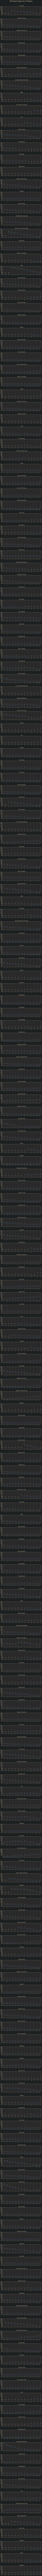

In [69]:
# Create line graphs of the values of each project over all generations

def all_gens_full_plot(player_count, ignore_prereqs=True):
    fig, axes = plt.subplots(208, figsize=(10,600))
    fig.subplots_adjust(top=0.978, hspace=0.5)
    fig.suptitle(f'All Project Values for {player_count} Players', fontsize = 24)
    
    
    if player_count == 2:
        x_list = [x for x in range(1,14)]
    elif player_count == 3:
        x_list = [x for x in range(1,12)]
    else:
        x_list = [x for x in range(1,11)]
    
    max_range = max(x_list) + 1
    
    def plot_project(row):
        ax = plt.subplot(208, 1, (row.name+1))
        ax.set_title(row.Title)
        y_list = []
        for i in range(1,max_range):
            if pd.isna(row[f'Value Gen{i}']):
                y_list.append(np.nan)
            else: y_list.append(row[f'Value Gen{i}'])
        plt.plot(x_list, y_list, marker='.')
        ax.set_xticks(x_list)
        ax.set_yticks([-25,0,25,50,75,100,125,150,175,200,225])
        
        for x, y in zip(x_list, y_list):
            if pd.isna(y):
                plt.annotate(str('N/A'),
                             (x,0),
                             textcoords='offset points',
                             xytext=(0,10),
                             ha='center')
            else:
                plt.annotate(str(y), 
                             (x,y), 
                             textcoords='offset points', 
                             xytext=(0,10),
                             ha='center')

    values_per_player_count = all_gens_full_db(player_count, ignore_prereqs)
    values_per_player_count.apply(plot_project, axis=1)
    
    plt.show()
    
all_gens_full_plot(2, ignore_prereqs=False)

#### Highest and Lowest Values per Gen

A DataFrame is presented with the most and least valuable projects for each generation with a given player count.
<br></br>

<details>
    <summary>Methodology</summary>

First the number of generations is set based on the player count, and then the empty DataFrame `min_and_max_values` is created. `all_gens_full_db()` is called and then the following two projects are removed: "Insulation", and "Power Infrastructure". Due to the fact that the value of these two projects is purely contextual, they will always carry a negative value, which skews the results.
    
The generations are looped through and the highest and lowest value projects for each are added to `min_and_max_values`.

</details>

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

In [70]:
# For each generation, find the projects with the highest and lowest values respectively

def all_gens_best_project_per(player_count, ignore_prereqs=True):
    
    # set the number of generations to the average for the given player count
    if player_count == 2: gens = 13
    elif player_count == 3: gens = 11
    else: gens = 10
    
    # create an empty DataFrame and a project value reference DataFrame with the given
    # player count and with or without prerequisites
    min_and_max_values = pd.DataFrame(columns=['Highest Value', 'Lowest Value'])
    database = all_gens_full_db(player_count, ignore_prereqs)
    
    # remove the projects "Insulation" and "Power Infrastructure" from the reference
    # DataFrame as they skew the results
    database = database[~database.Title.isin(['Insulation', 'Power Infrastructure'])]
    
    # loop through each generation, pulling the title and value of the most and least
    # valuable projects in that generation, then adding them as a new row in
    # min_and_max_values
    for i in range(1,gens+1):
        highest = database.nlargest(1, f'Value Gen{i}', keep='all').reset_index()
        highest_title = highest.loc[0, 'Title']
        highest_value = highest.loc[0, f'Value Gen{i}']
        
        lowest = database.nsmallest(1, f'Value Gen{i}', keep='all').reset_index()
        lowest_title = lowest.loc[0, 'Title']
        lowest_value = lowest.loc[0, f'Value Gen{i}']
        
        new_row = {'Highest Value':f'{highest_title} ({highest_value})',
                   'Lowest Value':f'{lowest_title} ({lowest_value})'}
        
        min_and_max_values.loc[i] = new_row
        
    return min_and_max_values
        
    
all_gens_best_project_per(2, ignore_prereqs=False)

Highest Value                    Lowest Value
1         Underground Detonation (156)  Magnetic Field Generator (-44)
2         Underground Detonation (124)  Magnetic Field Generator (-37)
3   Beam from a Thorium Asteroid (116)  Magnetic Field Generator (-30)
4                          Birds (166)  Magnetic Field Generator (-23)
5                          Birds (153)          Underground City (-18)
6                          Birds (140)          Underground City (-15)
7                          Birds (125)          Underground City (-12)
8                          Birds (109)      Corporate Stronghold (-12)
9                       Predators (95)      Corporate Stronghold (-13)
10                      Predators (80)      Corporate Stronghold (-14)
11                   Large Convoy (67)      Corporate Stronghold (-15)
12                   Large Convoy (72)                   Soletta (-23)
13                   Large Convoy (77)                   Soletta (-35)

#### Value Ranges

A DataFrame is presented with the range of values over the course of a game for each project.
<br></br>

<details>
    <summary>Methodology</summary>

The number of generations is determined by the player count then the full project DataFrame is looped through and the range in values is determined for each project and added as a new column. Finally the project with the highest range is returned.

</details>

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

In [71]:
# Find the project with the largest value range over the course of a game
def value_ranges(player_count, ignore_prereqs=True):
    
    # create the project value reference DataFrame
    database = all_gens_full_db(player_count, ignore_prereqs)
    
    # determine number of generations based on player count
    if player_count == 2: gens = 13
    elif player_count == 3: gens = 11
    else: gens = 10
    
    # make a list containing all of the eligible values for a project across all generations,
    # then find the range by subtracting the max value by the min value
    def find_value_range(row):

        value_list = []
        for i in range(1, gens+1):
            if pd.notna(row[f'Value Gen{i}']):
                value_list.append(row[f'Value Gen{i}'])
        value_range = max(value_list) - min(value_list)
        return value_range
    
    # apply find_value_range to all projects and move the 'Value_Range' column to the front
    # of the DataFrame
    database['Value_Range'] = database.apply(find_value_range, axis=1)
    col = database.pop('Value_Range')
    database.insert(0, col.name, col)
    database = database.sort_values(by=['Value_Range'], ascending=False).reset_index(drop=True)
    return database
    
value_ranges(2, ignore_prereqs=False)

Value_Range                         Title       Game       Type  \
0            162        Underground Detonation       base     active   
1            155                 Space Mirrors       base     active   
2            154                         Birds       base     active   
3            147                       Soletta       base  automated   
4            131  Beam from a Thorium Asteroid       base  automated   
5            108            Giant Space Mirror       base  automated   
6            100                     Predators       base     active   
7             98                Mass Converter  corporate     active   
8             97                    Steelworks       base     active   
9             95             Quantum Extractor  corporate     active   
10            92   Aerobraked Ammonia Asteroid       base      event   
11            92                 Heat Trappers       base  automated   
12            90                    Lunar Beam       base  automated   
13            90                  Fusion Power       base  automated   
14            86         Tectonic Stress Power       base  automated   
15            86                Energy Tapping  corporate  automated   
16            85                 Ore Processor       base     active   
17            84                   Mohole Area       base  automated   
18            84                 Nuclear Power       base  automated   
19            84          Power Infrastructure  corporate     active   
20            82                    Power Grid       base  automated   
21            81             Industrial Center  corporate     active   
22            80      Magnetic Field Generator       base  automated   
23            79        Nitrogen-Rich Asteroid       base      event   
24            79                Security Fleet  corporate     active   
25            74         Terraforming Ganymede  corporate  automated   
26            73                     Ironworks       base     active   
27            72              Geothermal Power       base  automated   
28            71                    AI Central  corporate     active   
29            70               Aquifer Pumping       base     active   
30            69     Artificial Photosynthesis       base  automated   
31            66         Water Splitting Plant       base     active   
32            62               Regolith Eaters       base     active   
33            62                  Large Convoy       base      event   
34            60       Power Supply Consortium  corporate  automated   
35            60                Peroxide Power       base  automated   
36            60           Industrial Microbes       base  automated   
37            59           Extreme Cold Fungus       base     active   
38            58    Asteroid Mining Consortium  corporate  automated   
39            51                          Ants       base     active   
40            51                 Energy Saving       base  automated   
41            51          Io Mining Industries  corporate  automated   
42            48               Restricted Area  corporate     active   
43            48   Great Escarpment Consortium  corporate  automated   
44            48                 GHG Factories       base  automated   
45            48               Physics Complex  corporate     active   
46            45                Space Elevator  corporate     active   
47            45               Ganymede Colony       base  automated   
48            45               Asteroid Mining       base  automated   
49            45     Nitrite Reducing Bacteria       base     active   
50            44                       Insects       base  automated   
51            43            Methane from Titan       base  automated   
52            42        Import of Advanced GHG       base      event   
53            41                     Livestock       base     active   
54            41       Designed Microorganism

#### Value Ranges Histogram

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

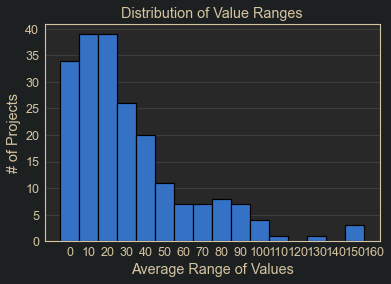

In [72]:
# Create a histogram of Project Value Ranges

database = value_ranges(2, ignore_prereqs=False)

fig, ax = plt.subplots()

bins = np.arange(0, 170, 10)
ax.hist(database.Value_Range, bins-5, edgecolor='black', linewidth=1.2, zorder=2)

ax.set_xticks(bins)
ax.set_yticks(range(0,41,5))

ax.set_xlabel('Average Range of Values')
ax.set_ylabel('# of Projects')
ax.set_title('Distribution of Value Ranges')
ax.grid(False)
ax.grid(axis='y', alpha=.1, color='#ffffff', zorder=1)

#### Average Values

A DataFrame is presented with each project's average value over the course of a game.
<br></br>

<details>
    <summary>Methodology</summary>

The number of generations is determined by the player count then the full project DataFrame is looped through and the average value is determined for each project and added as a new column.

</details>

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

In [73]:
# Find each project's average value

def average_values(player_count, ignore_prereqs=True):
    
    # create the project value reference DataFrame
    database = all_gens_full_db(player_count, ignore_prereqs)
    
    # determine number of generations based on player count
    if player_count == 2: gens = 13
    elif player_count == 3: gens = 11
    else: gens = 10
    
    # make a list of the values across every generation and average them
    def find_average_value(row):
            
        value_list = []
        for i in range(1, gens+1):
            if pd.notna(row[f'Value Gen{i}']):
                value_list.append(row[f'Value Gen{i}'])
        average_value = np.mean(value_list)
        return int(average_value)
    
    # apply find_average_value to all projects and move the 'Average_Value' column to the
    # front of the DataFrame
    database['Average_Value'] = database.apply(find_average_value, axis=1)
    col = database.pop('Average_Value')
    database.insert(0, col.name, col)
    database = database.sort_values(by=['Average_Value'], ascending=False).reset_index(drop=True)
    
    return database

average_values(2, ignore_prereqs=False)

Average_Value                         Title       Game       Type  \
0               95                         Birds       base     active   
1               85           Extreme Cold Fungus       base     active   
2               84                     Predators       base     active   
3               59        Nitrogen-Rich Asteroid       base      event   
4               53                Security Fleet  corporate     active   
5               50  Beam from a Thorium Asteroid       base  automated   
6               50                Lake Marineris       base  automated   
7               48       Anti-Gravity Technology  corporate     active   
8               45                  Large Convoy       base      event   
9               45            Giant Ice Asteroid       base      event   
10              43      Water Import from Europa       base     active   
11              43                    Steelworks       base     active   
12              43                 Space Mirrors       base     active   
13              43          Io Mining Industries  corporate  automated   
14              43                    AI Central  corporate     active   
15              42         Tectonic Stress Power       base  automated   
16              42                   Deimos Down       base      event   
17              42                Mass Converter  corporate     active   
18              40        Underground Detonation       base     active   
19              40               Physics Complex  corporate     active   
20              39                Earth Catapult  corporate     active   
21              39                    Power Grid       base  automated   
22              38       Designed Microorganisms       base  automated   
23              38                       Soletta       base  automated   
24              38               Aquifer Pumping       base     active   
25              38                 Ore Processor       base     active   
26              37            Giant Space Mirror       base  automated   
27              36         Equatorial Magnetizer       base     active   
28              36             Quantum Extractor  corporate     active   
29              35   Aerobraked Ammonia Asteroid       base      event   
30              34             Imported Nitrogen       base      event   
31              34                  Arctic Algae       base     active   
32              33                          Ants       base     active   
33              33                     Ironworks       base     active   
34              33    Asteroid Mining Consortium  corporate  automated   
35              33                       Farming       base  automated   
36              32            Methane from Titan       base  automated   
37              32                       Insects       base  automated   
38              32      Interstellar Colony Ship  corporate      event   
39              32                Space Elevator  corporate     active   
40              31                  Fusion Power       base  automated   
41              30                 Nuclear Power       base  automated   
42              30                    Lunar Beam       base  automated   
43              30                  Kelp Farming       base  automated   
44              29                Tundra Farming       base  automated   
45              29         Water Splitting Plant       base     active   
46              28                      Mangrove       base  automated   
47              27          Immigration Shuttles       base  automated   
48              26               Asteroid Mining       base  automated   
49              26                   Mohole Area       base  automated   
50              26           Advanced Ecosystems       base  automated   
51              26                   Medical Lab  corporate  automated   
52              25                 Small Animals       base     active   
53       

#### Average Values Histogram

<br></br>
<sup>[analysis](#Analysis)</sup>  
<sup>[index](#Index:)</sup>

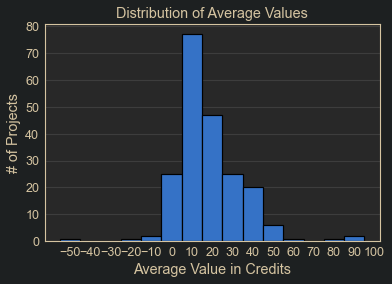

In [74]:
# Create a histogram to show the distribution of average values

database = average_values(2, ignore_prereqs=False)

fix, ax = plt.subplots()

bins = np.arange(-50, 110, 10)
ax.hist(database.Average_Value, bins-5, edgecolor='black', linewidth=1.2, zorder=2)

ax.set_xticks(bins)
ax.set_yticks(range(0,90,10))

ax.set_xlabel('Average Value in Credits')
ax.set_ylabel('# of Projects')
ax.set_title('Distribution of Average Values')
ax.grid(False)
ax.grid(axis='y', alpha=.1, color='#ffffff', zorder=1)

### Conclusion

The goal of this analysis was to take an extremely variable, context-heavy game with 208 unique cards and reduce each card to a single value through the calculation of hard variables and the averaging out of circumstantial ones. To determine the accuracy of the assessment, data from games in which every action was recorded was used to compare the total project values of all cards played by each player with their final scores.

Unfortunately the dataset used for assessment is exceptionally limited, comprising only five games, each with the same player count. It is impossible to glean much about the accuracy from this small of a sample size, yet the scant results are promising. Four out of the five games show correlation between the total project values of the players and their final scores. Within these four games, two of them show a close relationship between the ratios of the total project values and final scores.

<br></br>
[index](#Index:)

#### General Notes -

* Ignoring opportunity cost. This is why a card draw is worth only 4. Certain cards will be slightly devalued due to this, such as Business Contacts (where the extra two cards drawn and then discarded are not tallied)  
* Greeneries and Cities. The map point from a greenery is used in calculating the value of victory points, but it is not added to the value of the greenery standard project. Likewise, the potential map value of a city tile is not added to the value of the city standard project. The reasoning for this is that those map points/potential map points have been factored into determining the cost of the standard project.
* In most cases numbers are rounded only at the point of presenting the final card values.
* For the purposes of evaluation, it is assumed that there are always resources available to be removed from an opponent.

#### Project Notes -
* In the `per_scan()` function the event portion is focused solely on Media Archives. Only "all events played" is handled. If I add any expansions later on, I will need to update this if any cards rely on the number of events played by the current player only.
* For concision, I've only distinguished between tags played and tags showing for those tags that have any event versions. If I add any expansions, I'll have to reassess.  